In [2]:
import glob
import gzip
import os
import shutil
import sys
import time
from datetime import date
import numpy as np
import pandas as pd
import copy

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref="1900-01-01T00:00:00"):
    """from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, "s")).astype(np.int64)

def seconds_to_datetime(seconds, ref="1900-01-01"):
    """from seconds to datetime64"""
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit="s", origin=ref)

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [3]:
import cv2
import numpy as np
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

## CV2

In [59]:
def digitize(file, height_input = False):  
    # try:
    %matplotlib inline
    print(file)
    # Load the image
    img = cv2.imread(file)
    # plt.imshow(img)
    # plt.show()
    # plt.close()

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find the contour with the largest area (i.e., the plot data)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    plot_only = img[y+10:y+h-1, x+1:x+w-1]
    relative_y = y+10
    relative_x = x+1
    relative_y_xaxis =  y+h-1

    # Save the cropped image
    cv2.imwrite('test_plot_only.png', plot_only)

    # Show the cropped image
    # plt.imshow(plot_only)
    # plt.show()

    # Convert the contour to a numpy array and transpose it
    plot_data = largest_contour.squeeze().T

    # Print the plot data
    # print(plot_data)




    image = img[ 1272:1285, 20:500]
    plt.imshow(image)
    plt.show()
    plt.close()
    if np.mean(image) == 255:
        print('All white')
        return 0
    else:
        print('Not all white')

    image_l = image_resize(image, height = 50)
    gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    data = pytesseract.image_to_string(inverted, lang='eng', config= '--psm 7')
    # print(data)



    # print('start splitting image')

    im = cv2.imread("test_plot_only.png")

    # Define lower and upper limits of our blue
    BlueMax = np.array([128, 255, 255], np.uint8)
    BlueMin = np.array([90, 50, 70], np.uint8)

    # Go to HSV colourspace and get mask of blue pixels
    HSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    # plt.imshow(HSV)
    # plt.show()
    # plt.close()
    mask = cv2.inRange(HSV, BlueMin, BlueMax)

    # Make all pixels in mask white
    grid = copy.copy(im)
    grid[mask == 0] = [255, 255, 255]
    grid[0:, 0:15] = [255, 255, 255]


    im[mask > 0] = [255, 255, 255]
    im[0:100, 0:15] = [255, 255, 255]
    im[-2:, :] = [255, 255, 255]

    # plt.imshow(im)
    # plt.show()
    # plt.close()
    # plt.imshow(grid)
    # plt.show()
    # plt.close()
    cv2.imwrite("test_grid_only.png", grid)
    cv2.imwrite("test_data_only.png", im)



    # print("Analyzig grid:")

    grid = cv2.imread('test_grid_only.png')
    gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)

    dst = cv2.cornerHarris(gray, 5,19,0.07)
    dst = cv2.dilate(dst, None)

    # Get coordinates
    ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 
                0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids[1:]),(5,5), 
          (-1,-1),criteria)
    # To draw the corners
    for corner in corners:
        grid[int(corner[1]), int(corner[0])] = [0, 0, 255]
    corner_coords = np.asarray(corners, dtype = int)
    corner_coords = corner_coords[corner_coords[:,0] < np.max(corner_coords[:,0]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,1] < np.max(corner_coords[:,1]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,0] > np.max(corner_coords[:,0]) * 0.1]
    corner_coords = corner_coords[corner_coords[:,1] > np.max(corner_coords[:,1]) * 0.1]
    for co in corner_coords:
        grid = cv2.circle(grid, co, radius=4, color=(255, 0, 0), thickness=-1)
    # plt.imshow(grid)
    # plt.show()
    # plt.close()



    # choosing 2 points
    grid = cv2.imread('test_grid_only.png')
    # not on the very outside of the plot:
    maxcoord = np.argmax(np.sum(corner_coords, axis = 1))
    mincoord = np.argmin(np.sum(corner_coords, axis = 1))

    # coords_mean = meancoord
    coords_low = corner_coords[mincoord]
    coords_high = corner_coords[maxcoord]
    grid = cv2.circle(grid, coords_low, radius=4, color=(0, 0, 255), thickness=-1)
    grid = cv2.circle(grid, coords_high, radius=4, color=(0, 0, 255), thickness=-1)
    print('min: ', coords_low)
    print('max: ', coords_high)

    # plt.imshow(grid)
    # plt.show()
    # plt.close()



    rs_h = 50 # resize height
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C' #'--psm 6' # 'outputbase digits'
    matplotlib.rcParams["figure.figsize"] = (5, 3)
    whole_image = cv2.imread(file)

    # low_y_label = whole_image[relative_y + coords_low[1]-10: relative_y + coords_low[1]+10, relative_x-37:relative_x-1]
    # low_y_label = image_resize(low_y_label, height = 50)
    low_y_label = img[relative_y + coords_low[1]-10: relative_y + coords_low[1]+10, relative_x-37:relative_x-1]
    low_y_label = image_resize(low_y_label, height = rs_h)


    gray = cv2.cvtColor(low_y_label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    low_y_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
    print("low_y: ", low_y_val)

    plt.imshow(low_y_label)
    plt.show()
    plt.close()

    # high_y_label = whole_image[relative_y + coords_high[1]-10: relative_y + coords_high[1]+10, relative_x-40:relative_x-1]
    # high_y_label = image_resize(high_y_label, height = 50)
    high_y_label = img[relative_y + coords_high[1]-10: relative_y + coords_high[1]+10, relative_x-37:relative_x-1]
    high_y_label = image_resize(high_y_label, height = rs_h)

    gray = cv2.cvtColor(high_y_label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    high_y_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
    print("high_y: ", high_y_val)

    plt.imshow(high_y_label)
    plt.show()
    plt.close()

    # low_x_label = whole_image[relative_y_xaxis+1 : relative_y_xaxis+19, relative_x+coords_low[0]-30:relative_x+coords_low[0]+30]
    # low_x_label = image_resize(low_x_label, height = 50)
    # low_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_low[0]-15:relative_x+coords_low[0]+20]
    # low_x_label = image_resize(low_x_label, height = 50)
    low_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_low[0]-20:relative_x+coords_low[0]+30]
    low_x_label = image_resize(low_x_label, height = 50)

    gray = cv2.cvtColor(low_x_label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    low_x_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)

    print("low_x: ", low_x_val)

    plt.imshow(inverted)
    plt.show()
    plt.close()
                               
                               
    # high_x_label = whole_image[relative_y_xaxis+1 : relative_y_xaxis+19, relative_x+coords_high[0]-30:relative_x+coords_high[0]+30]
    # high_x_label = image_resize(high_x_label, height = 50)
    # high_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_high[0]-15:relative_x+coords_high[0]+20]
    # high_x_label = image_resize(high_x_label, height = 50)
    high_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_high[0]-30:relative_x+coords_high[0]+30]
    high_x_label = image_resize(high_x_label, height = 50)

    gray = cv2.cvtColor(high_x_label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    cv2.threshold(image,100,255,cv2.THRESH_BINARY)

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    high_x_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
    print("high_x: ", high_x_val)
    

    plt.imshow(inverted) # high_x_label)
    plt.show()
    plt.close()

    print(low_x_val)
    if int(low_x_val) > 0 and int(low_x_val) > int("".join([x for x in high_x_val.split('\n\x0c')[0]  if x.isdigit() or x=='-'])):
        low_x_val = str(int(low_x_val) * -1)
        print('changed to: ', low_x_val)


    matplotlib.rcParams["figure.figsize"] = (20, 10)



    # converting axis texts to data:
    print('low: ',coords_low, low_x_val, low_y_val)
    print('high: ',coords_high, high_x_val, high_y_val)
    xa_p = [coords_low[0], coords_high[0]]
    xa_v = [273.15+int("".join([x for x in low_x_val.split('\n\x0c')[0]  if x.isdigit() or x=='-'])), 273.15+int("".join([x for x in high_x_val.split('\n\x0c')[0]  if x.isdigit() or x=='-']))]
    ya_p = [coords_low[1], coords_high[1]]
    ya_v = [int("".join([x for x in low_y_val.split('\n\x0c')[0]  if x.isdigit() or x=='-'])), int("".join([x for x in high_y_val.split('\n\x0c')[0]  if x.isdigit() or x=='-']))]
    display(xa_p)
    display(xa_v)
    display(ya_p)
    display(ya_v)
    print()



    # calculation of axis functions
    # x-axis
    x1 = xa_p[0]
    a = xa_v[0]
    x2 = xa_p[1]
    b = xa_v[1]

    m_T = (b - a) / (x2 - x1)
    c_T = a - m_T * x1
    def T(x):
        return m_T * x + c_T

    # y-axis
    if height_input:
        y1 = ya_p[0]
        ap = ya_v[0]
        y2 = ya_p[1]
        bp = ya_v[1]
    else: 
        y1 = ya_p[0]
        ap = np.log(ya_v[0])
        y2 = ya_p[1]
        bp = np.log(ya_v[1])

    m = (bp - ap) / (y2 - y1)
    c = ap - m * y1
    def P(x):
        return m * x + c



    # selection of data points via contour of graph:
    graph = cv2.imread('test_data_only.png')
    edge = cv2.Canny(graph, 30, 200) 
    ans = []
    for y in range(0, edge.shape[0]):
        for x in range(0, edge.shape[1]):
            if edge[y, x] != 0:
                ans = ans + [[x, y]]
    ans = np.array(ans)

    # print(ans.shape)
    # print(ans[0:10, :])

    for co in ans[:]:
        image = cv2.circle(graph, co, radius=4, color=(255, 0, 0), thickness=-1)
    # plt.imshow(image)
    # plt.show()
    # plt.close()


    unique_steps = []
    for i in range(np.min(ans[:,1]), np.max(ans[:,1])+1):
        step = ans[ans[:,1] == i]
        if len(step) > 1:
            mean_step = (np.mean(step, axis=0))
            unique_steps.append([int(mean_step[0]), int(mean_step[1])])
        elif len(step) == 1:
            unique_steps.append([int(step[0][0]), (step[0][1])])
    unique_steps


    # points to data with functions:
    out = {}
    # out['press'] = np.exp(P(ans[0::20][:,1]))
    # out['temp'] = (T(ans[0::20][:,0]))
    if height_input:
        out['press'] = P(np.array(unique_steps)[:,1])
    else:
        out['press'] = np.exp(P(np.array(unique_steps)[:,1]))
    out['temp'] = T(np.array(unique_steps)[:,0])
    df = pd.DataFrame.from_dict(out)
    df = df.sort_values('press')
    if height_input:
        df.to_csv('./out_height/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    else:
        df.to_csv('./out_data/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    # except Exception as e:
    #     print(str(e))
    #     return 0
    return df

./height_data/sc_Vaisala_1_.png


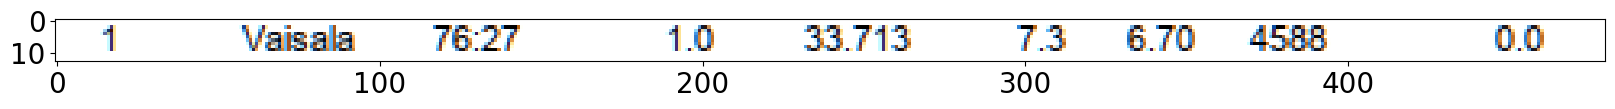

Not all white
min:  [189 135]
max:  [1376 1011]
low_y:  30



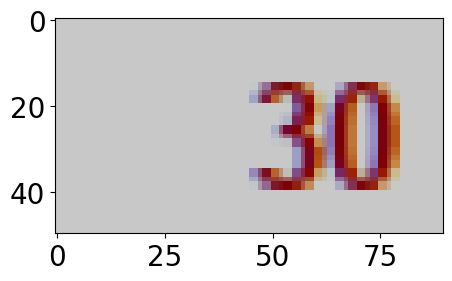

high_y:  6



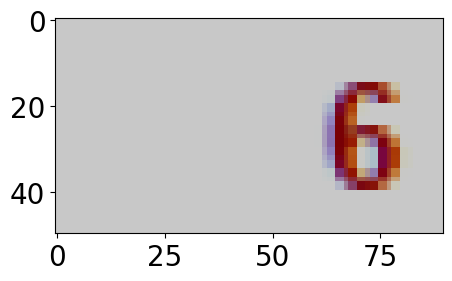

low_x:  -70



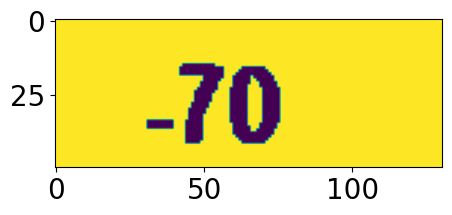

high_x:  0



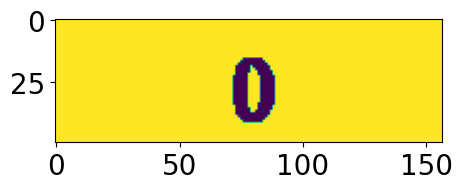

-70

low:  [189 135] -70
 30

high:  [1376 1011] 0
 6



[189, 1376]

[203.14999999999998, 273.15]

[135, 1011]

[30, 6]


./height_data/sc_Vaisala_10_.png


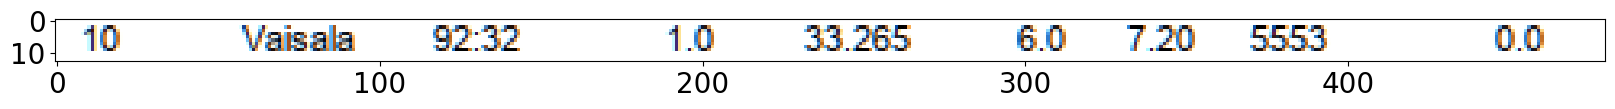

Not all white
min:  [188 120]
max:  [1437 1008]
low_y:  30



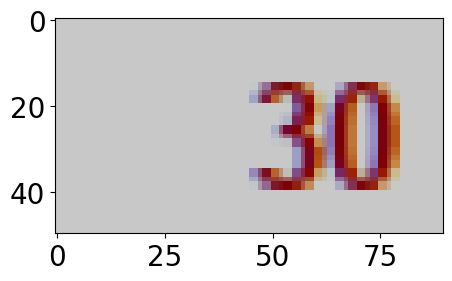

high_y:  6



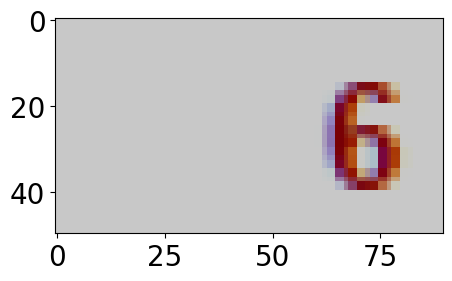

low_x:  -70



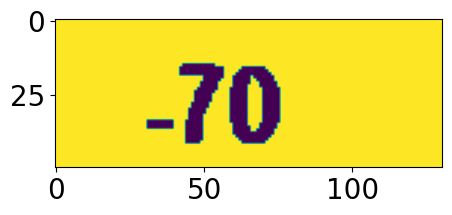

high_x:  0



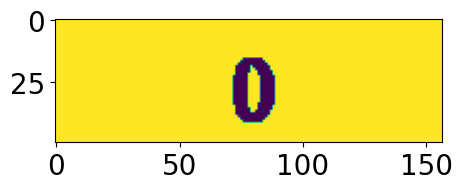

-70

low:  [188 120] -70
 30

high:  [1437 1008] 0
 6



[188, 1437]

[203.14999999999998, 273.15]

[120, 1008]

[30, 6]


./height_data/sc_Vaisala_9_.png


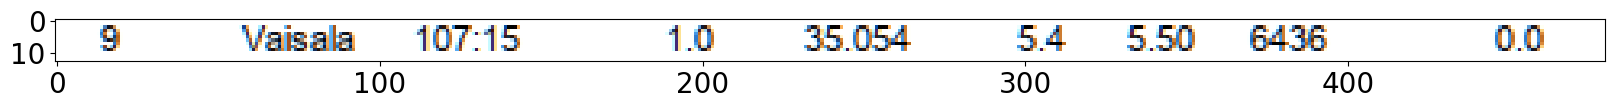

Not all white
min:  [199 106]
max:  [1405 1019]
low_y:  32



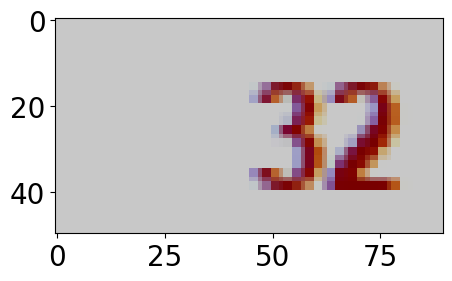

high_y:  6



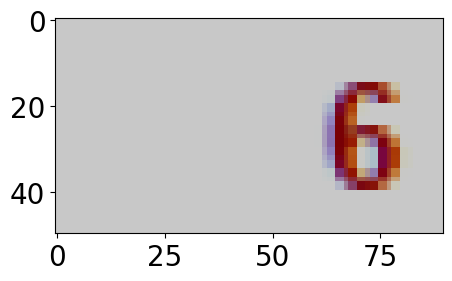

low_x:  -70



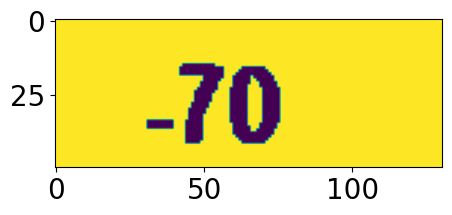

high_x:  0



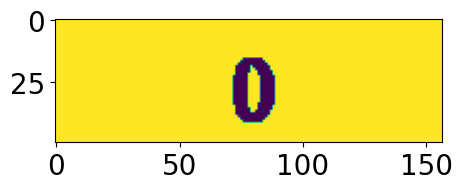

-70

low:  [199 106] -70
 32

high:  [1405 1019] 0
 6



[199, 1405]

[203.14999999999998, 273.15]

[106, 1019]

[32, 6]


./height_data/sc_Vaisala_7_.png


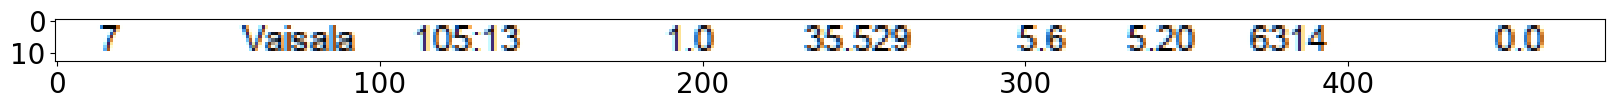

Not all white
min:  [173 121]
max:  [1621 1022]
low_y:  32



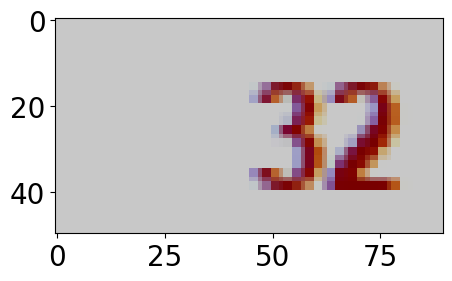

high_y:  6



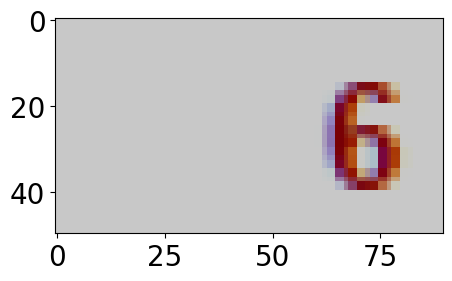

low_x:  -70



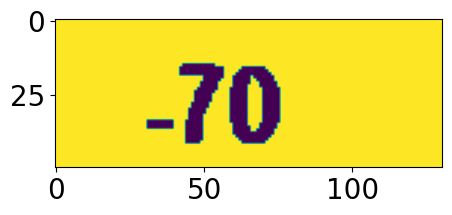

high_x:  10



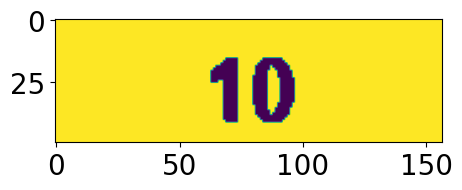

-70

low:  [173 121] -70
 32

high:  [1621 1022] 10
 6



[173, 1621]

[203.14999999999998, 283.15]

[121, 1022]

[32, 6]


./height_data/sc_Vaisala_6_.png


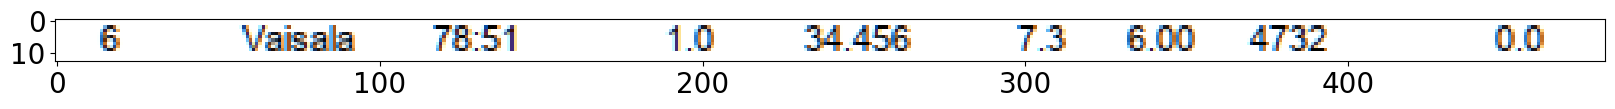

Not all white
min:  [211 159]
max:  [1447 1016]
low_y:  30



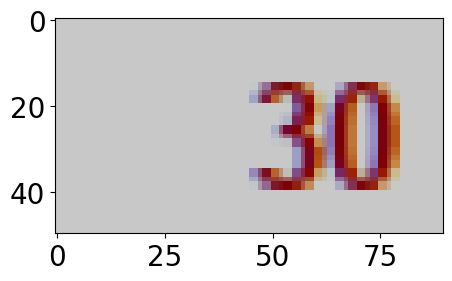

high_y:  6



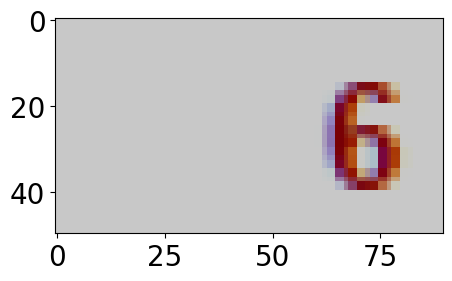

low_x:  -70



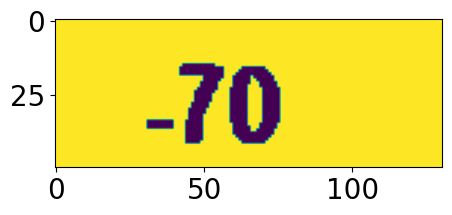

high_x:  0



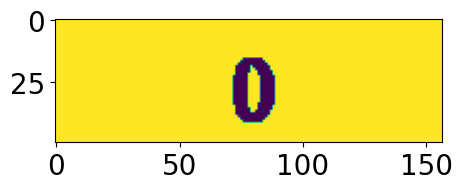

-70

low:  [211 159] -70
 30

high:  [1447 1016] 0
 6



[211, 1447]

[203.14999999999998, 273.15]

[159, 1016]

[30, 6]


./height_data/sc_Vaisala_4_.png


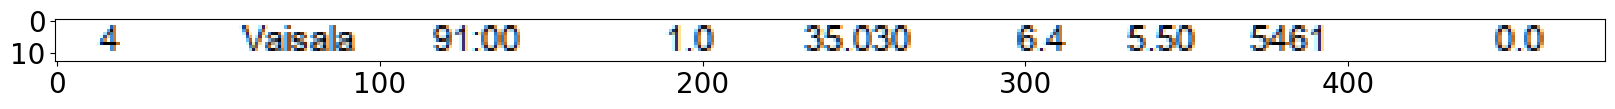

Not all white
min:  [181 106]
max:  [1421 1019]
low_y:  32



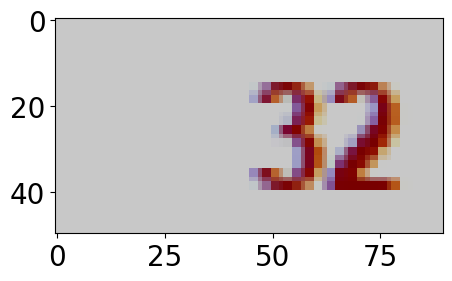

high_y:  6



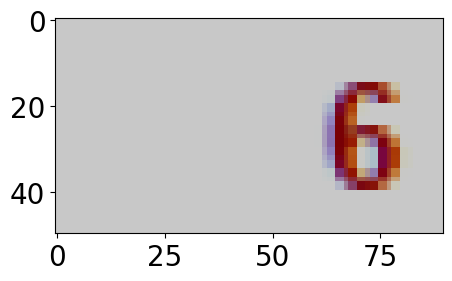

low_x:  -70



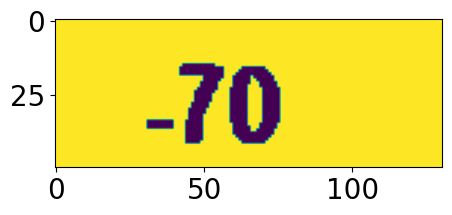

high_x:  0



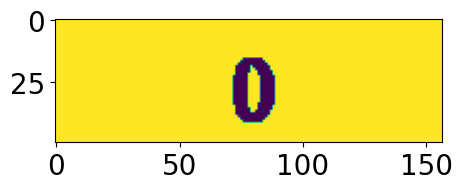

-70

low:  [181 106] -70
 32

high:  [1421 1019] 0
 6



[181, 1421]

[203.14999999999998, 273.15]

[106, 1019]

[32, 6]


./height_data/sc_Vaisala_5_.png


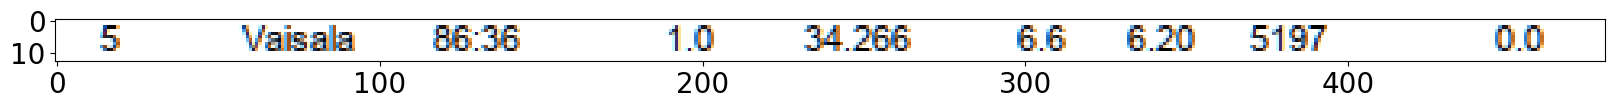

Not all white
min:  [213 153]
max:  [1401 1015]
low_y:  30



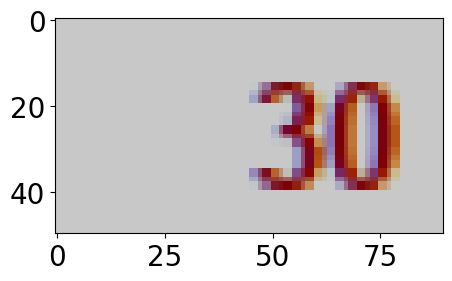

high_y:  6



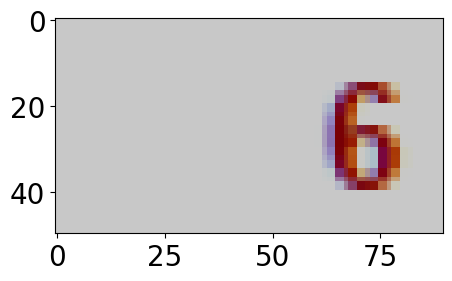

low_x:  -70



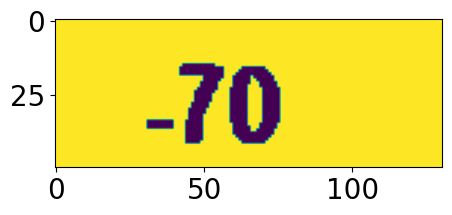

high_x:  0



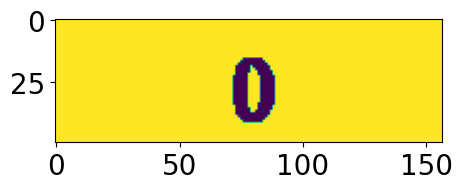

-70

low:  [213 153] -70
 30

high:  [1401 1015] 0
 6



[213, 1401]

[203.14999999999998, 273.15]

[153, 1015]

[30, 6]


./height_data/sc_Vaisala_8_.png


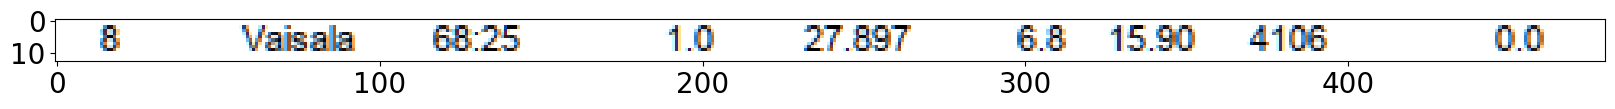

Not all white
min:  [183 172]
max:  [1433  965]
low_y:  24



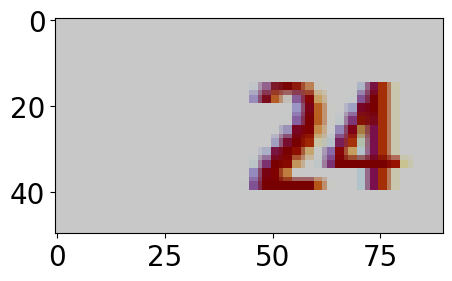

high_y:  6



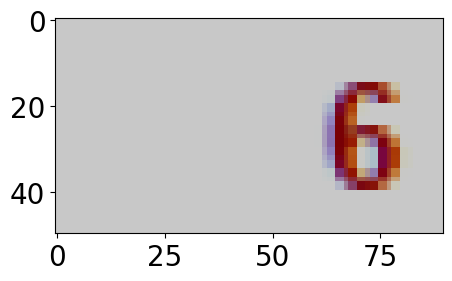

low_x:  -70



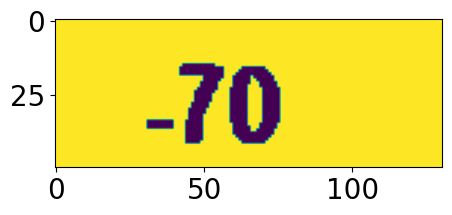

high_x:  0



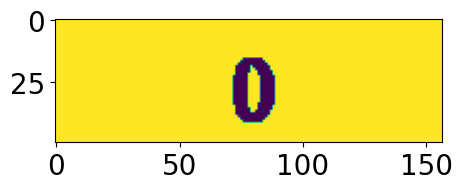

-70

low:  [183 172] -70
 24

high:  [1433  965] 0
 6



[183, 1433]

[203.14999999999998, 273.15]

[172, 965]

[24, 6]


./height_data/sc_Vaisala_3_.png


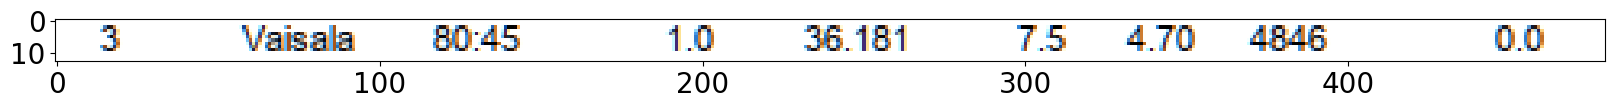

Not all white
min:  [189 142]
max:  [1441 1026]
low_y:  32



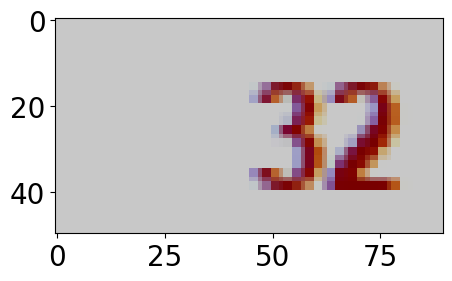

high_y:  6



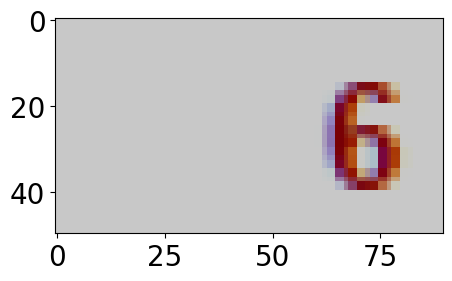

low_x:  -70



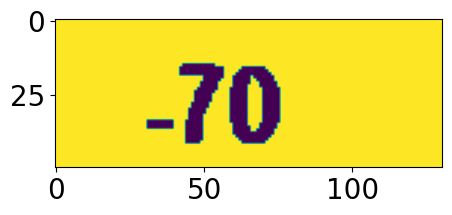

high_x:  0



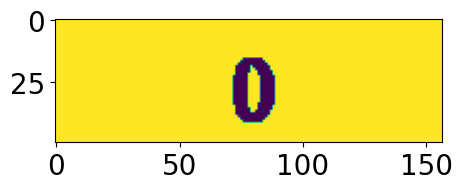

-70

low:  [189 142] -70
 32

high:  [1441 1026] 0
 6



[189, 1441]

[203.14999999999998, 273.15]

[142, 1026]

[32, 6]


./height_data/sc_Vaisala_2_.png


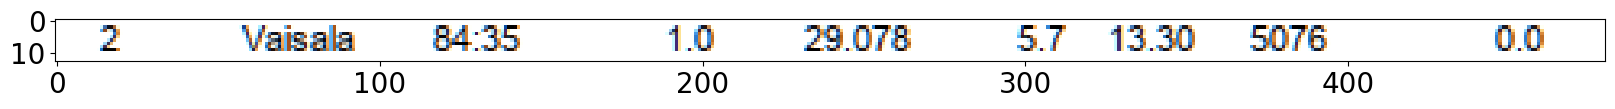

Not all white
min:  [206 130]
max:  [1425  976]
low_y:  26



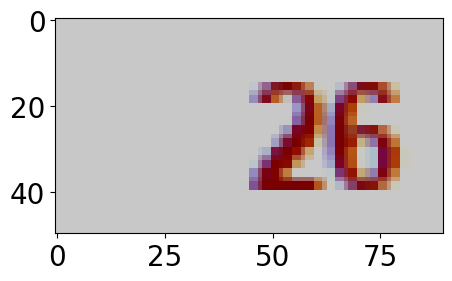

high_y:  6



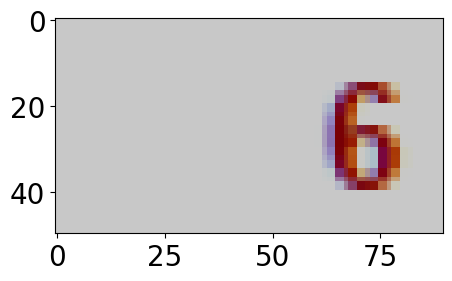

low_x:  -70



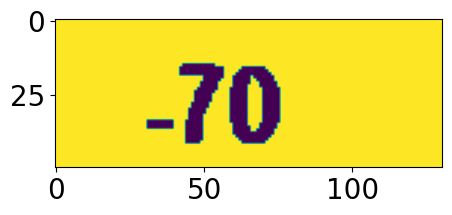

high_x:  0



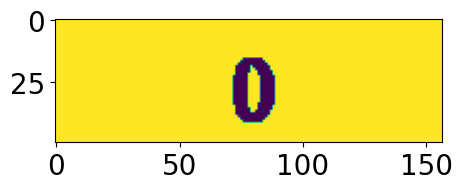

-70

low:  [206 130] -70
 26

high:  [1425  976] 0
 6



[206, 1425]

[203.14999999999998, 273.15]

[130, 976]

[26, 6]

In [60]:
# for j in range(1,11):
for i in glob.glob('./height_data/sc_Vaisala_*_.png'): # MKII_'+str(j)+'
    df = digitize(i, height_input = True)

In [23]:
vais_df = pd.read_csv('./vaisala_ascents.csv')
vais_df.date_time.drop_duplicates()

0         07-02-2005 10:01:53.551
4588      07-02-2005 14:57:50.481
9664      07-02-2005 19:31:41.965
14510     08-02-2005 05:13:16.722
19971     08-02-2005 10:00:56.553
25168     08-02-2005 15:03:03.289
29900     08-02-2005 19:33:03.372
36214     09-02-2005 05:12:00.618
40320     09-02-2005 10:05:05.418
46756     09-02-2005 14:59:48.197
52309     09-02-2005 19:17:51.222
56005     10-02-2005 05:02:13.432
61124     10-02-2005 09:58:41.940
66680     10-02-2005 14:57:54.734
73793     10-02-2005 19:00:19.242
80991     11-02-2005 05:02:45.185
86662     11-02-2005 15:05:21.407
92183     11-02-2005 18:31:58.407
93678     12-02-2005 15:00:05.867
100097    12-02-2005 18:36:55.168
106067    14-02-2005 05:06:57.494
111602    14-02-2005 10:08:04.684
118163    14-02-2005 15:00:54.504
125910    14-02-2005 18:00:36.448
128961    15-02-2005 05:16:46.851
136564    15-02-2005 10:03:06.727
143057    15-02-2005 15:01:34.429
146662    15-02-2005 18:11:25.926
152128    16-02-2005 05:11:08.125
157352    16-0

## pressure converted and xls

In [5]:
def find_nearest(array, value, array_matching = np.nan):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.isnan(array_matching).all():
        return array[idx]
    else:
        return array_matching[idx]


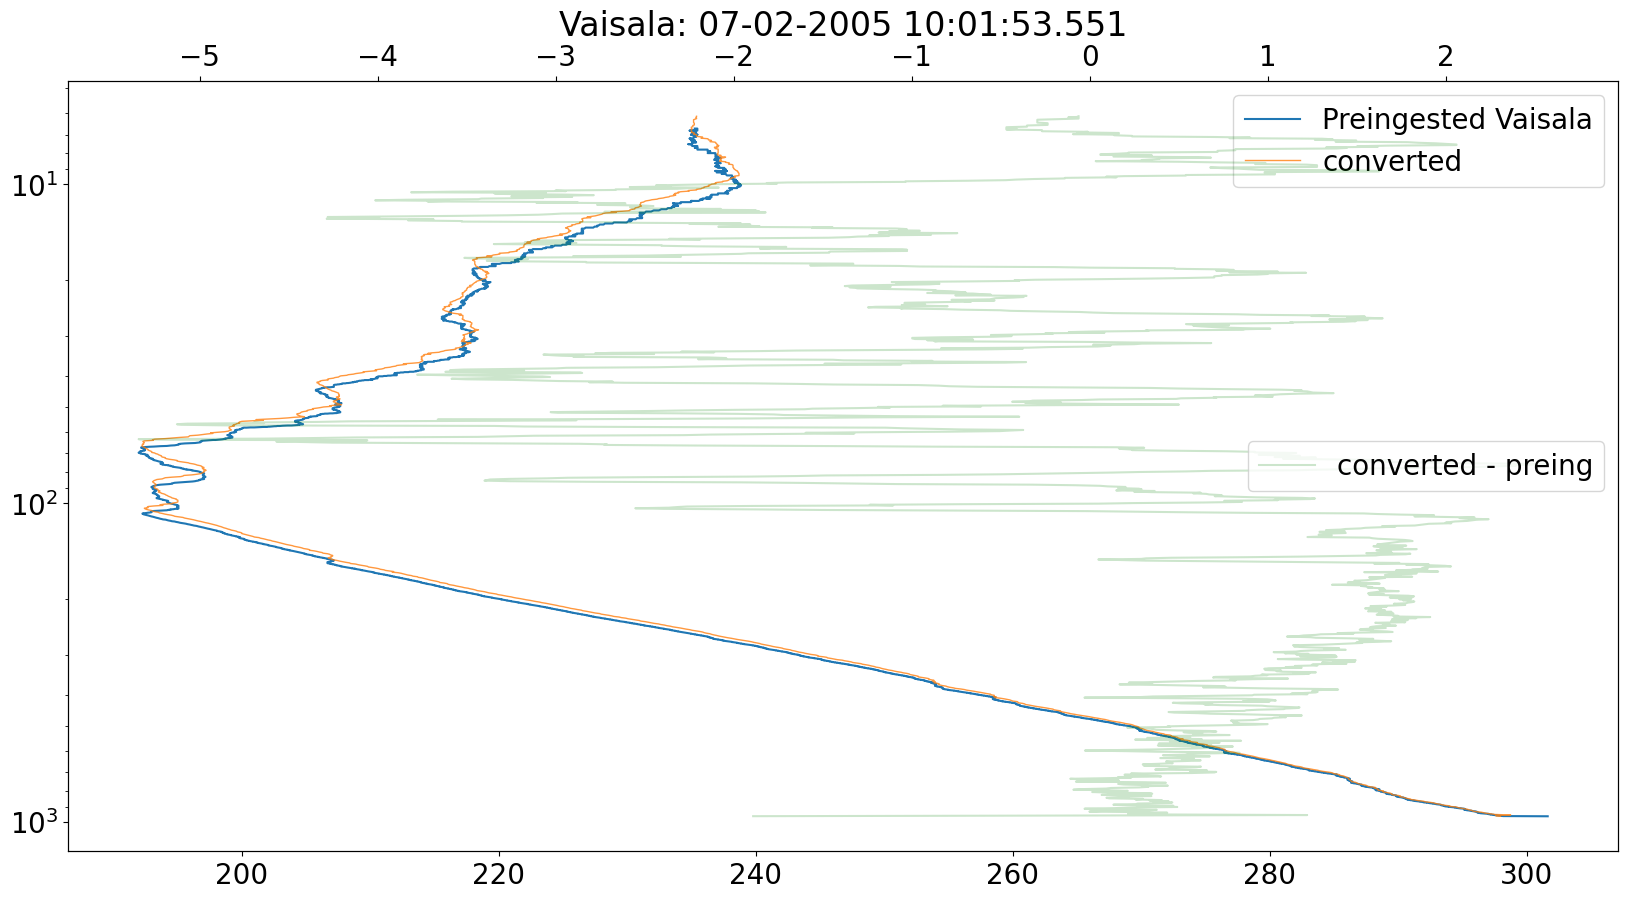

-0.04973249761251386


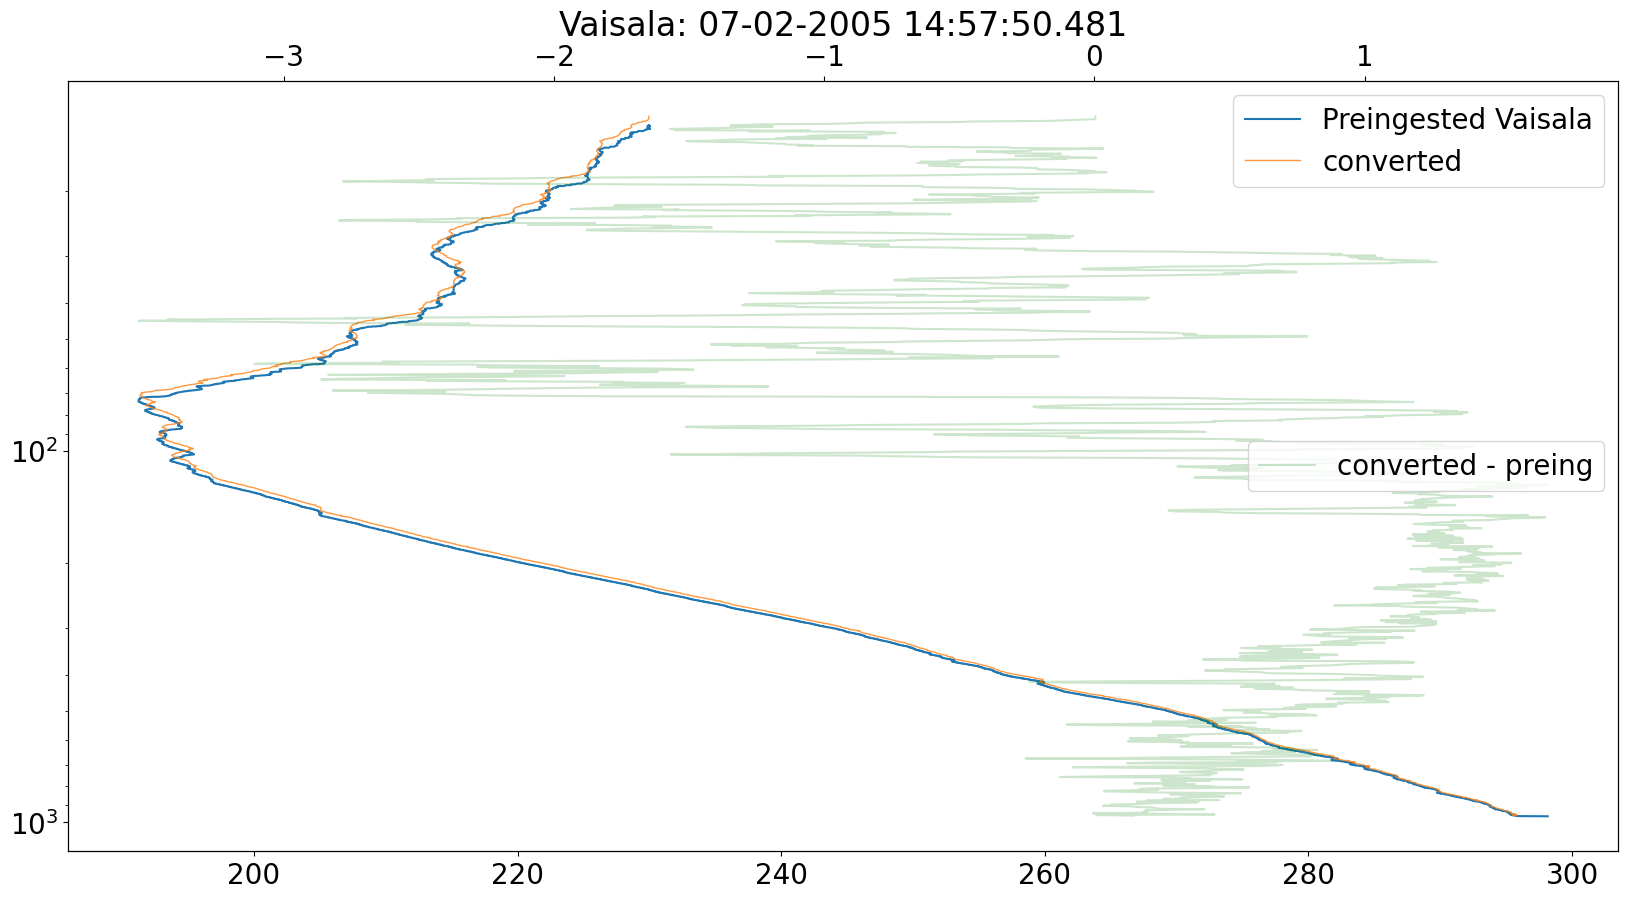

0.10986658514952351


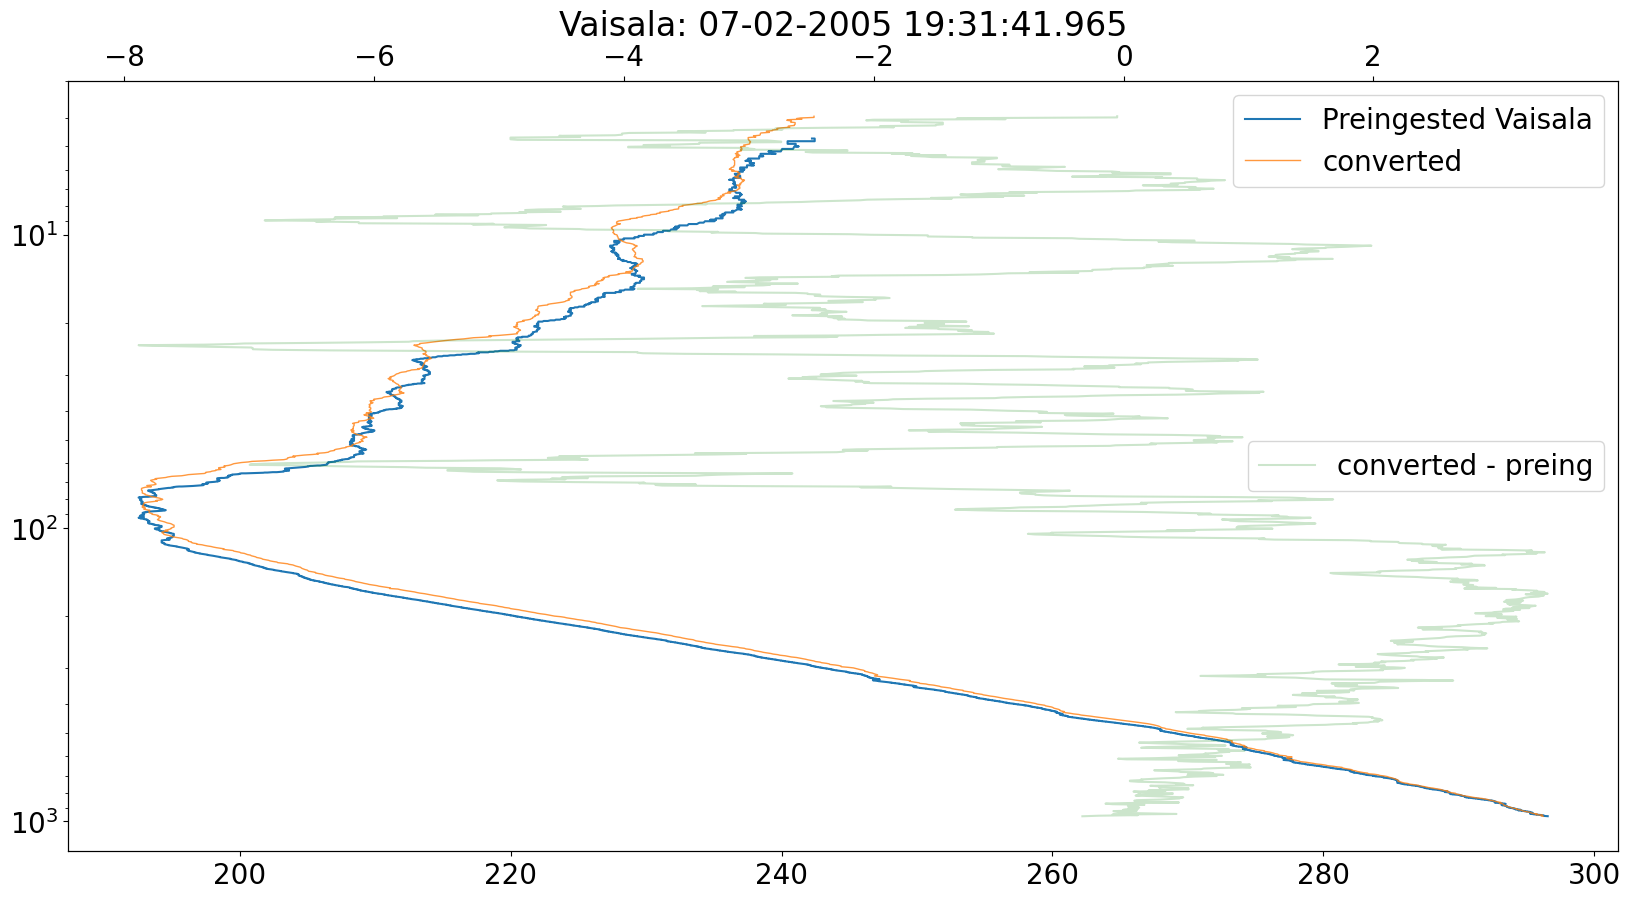

-0.357365937733018


In [140]:
ascs = ['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
for i in range(len(ascs)):
    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs[i]]
    vais_df = vais_df[vais_df.pressure > 0]
    vais_df.temperature = vais_df.temperature + 273.15
    df = pd.read_csv(glob.glob('./out_data/Vaisala_'+str(i+1)+'.csv')[0])
    plt.plot(vais_df.temperature, vais_df.pressure, label='Preingested Vaisala')#, alpha = 0.4, linewidth = 6)
    plt.plot(df.temp, df.press, alpha = 0.8, linewidth = 1, label='converted')
    
    plt.legend()
    plt.title('Vaisala: ' + ascs[i])
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_ylim(ax.get_ylim()[::-1])
    
    ax2= ax.twiny()
    diff = []
    for lev_p, lev_t in zip(df.press, df.temp):
        diff.append(lev_t - find_nearest(np.array(vais_df.pressure), lev_p, np.array(vais_df.temperature)))
    ax2.plot(diff, df.press, color='green', alpha = 0.2, label = 'converted - preing')
    ax2.legend(loc='center right')
    plt.show()
    plt.close()
    print(np.mean(diff))

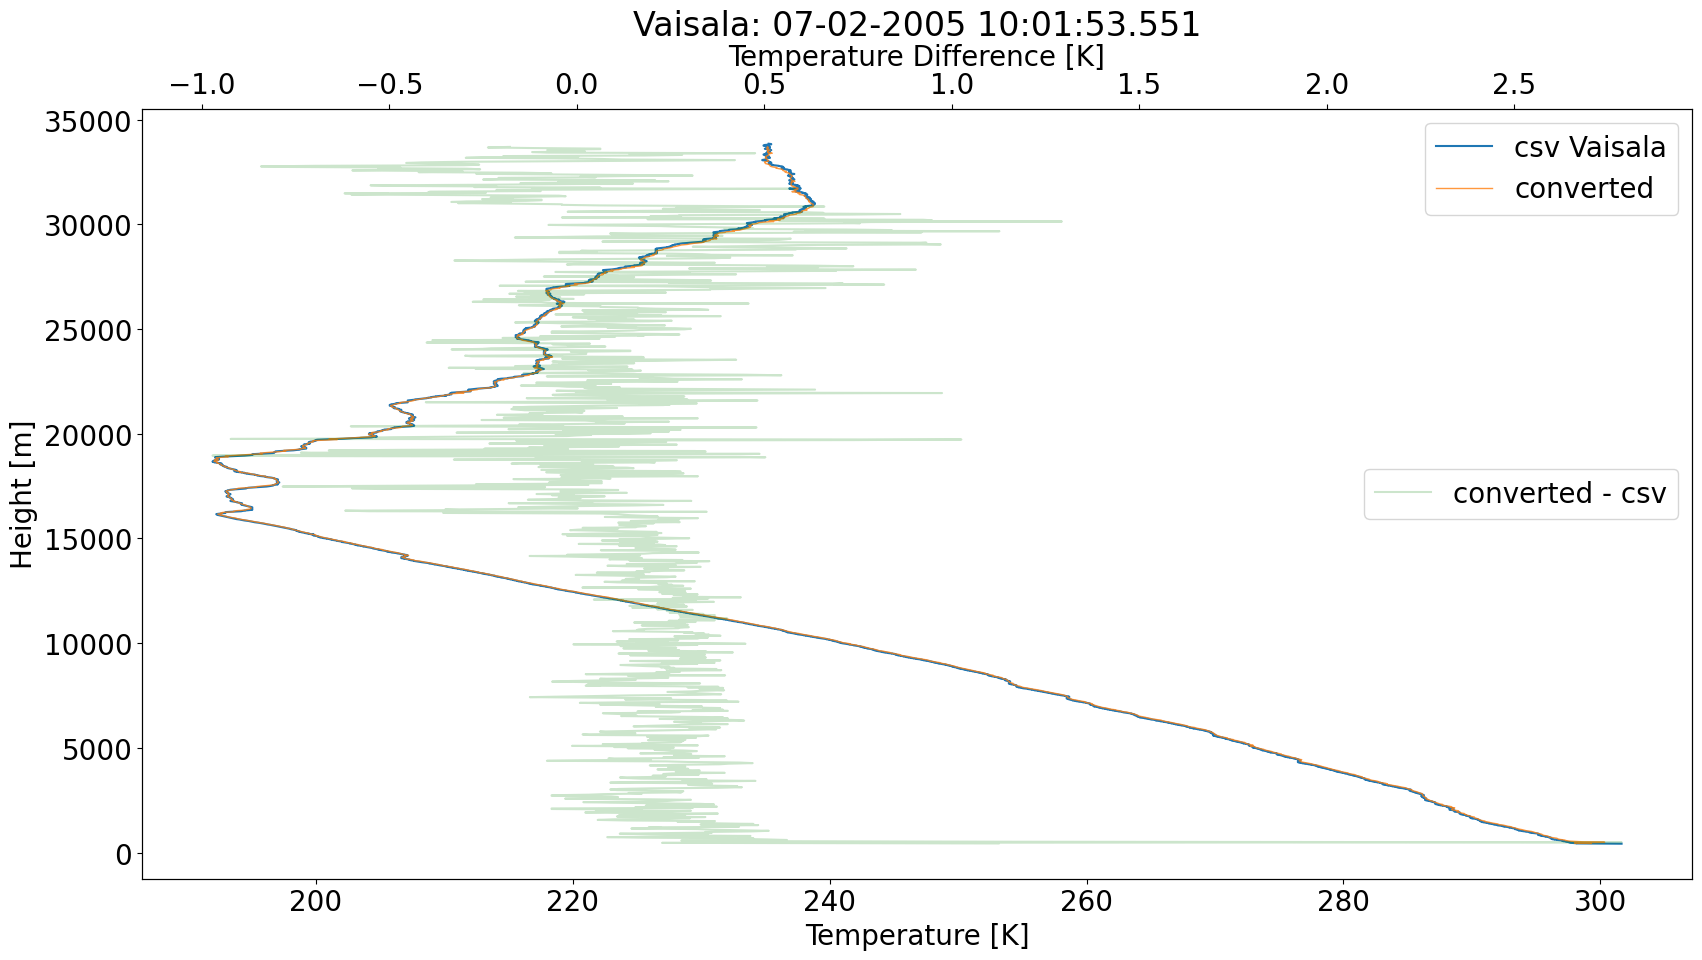

0.14396032464178907


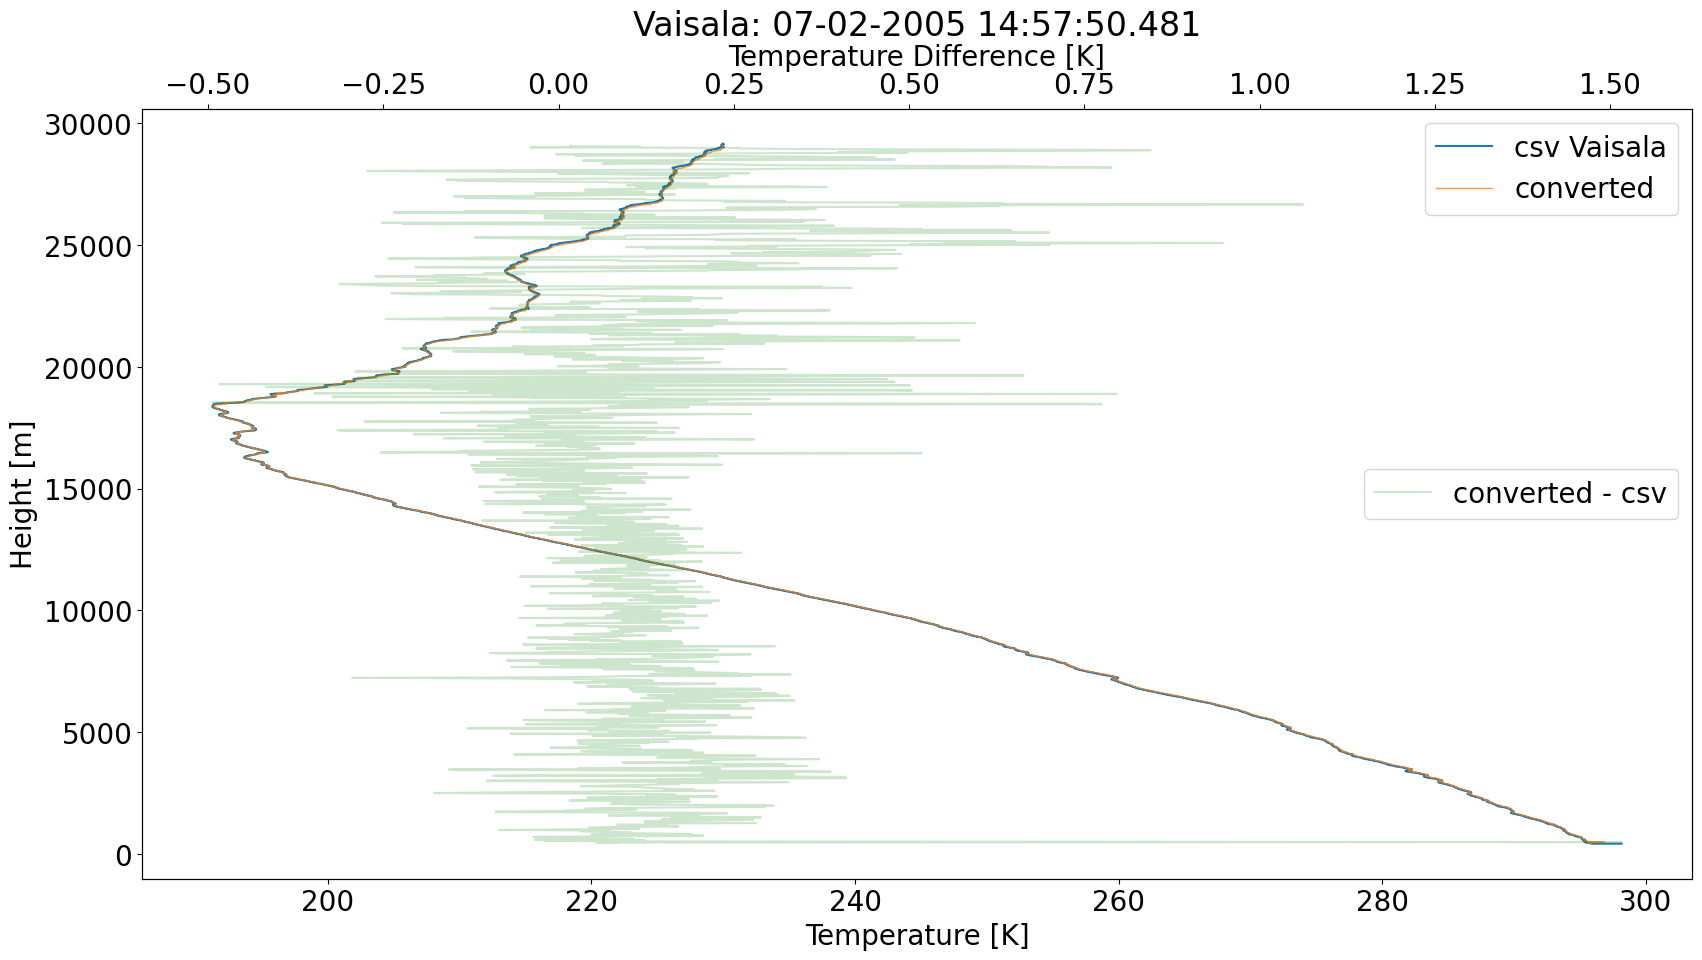

0.10939240355536949


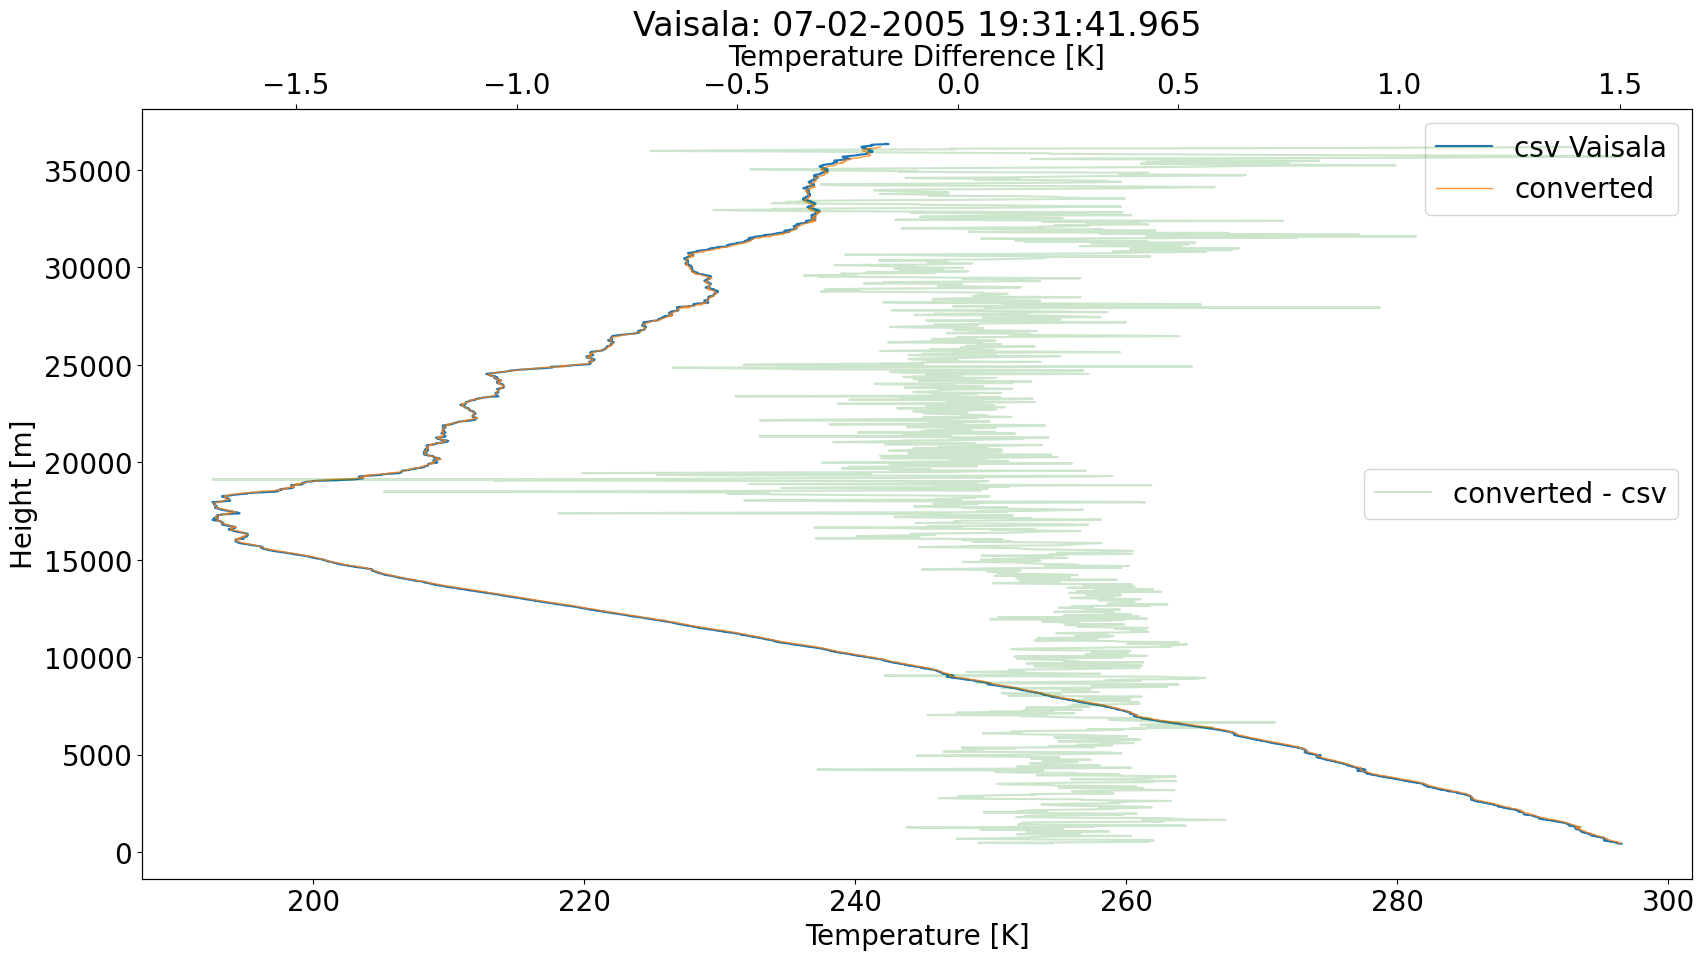

0.13983232091811792


In [9]:
ascs = ['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
for i in range(len(ascs)):
    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs[i]]
    vais_df = vais_df[vais_df.height > 0]
    vais_df.temperature = vais_df.temperature + 273.15
    df = pd.read_csv(glob.glob('./out_height/Vaisala_'+str(i+1)+'_.csv')[0])
    plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)
    plt.plot(df.temp, df.press*1000., alpha = 0.8, linewidth = 1, label='converted')
    
    plt.legend()
    plt.title('Vaisala: ' + ascs[i])
    ax = plt.gca()
    ax.set_xlabel('Temperature [K]')
    ax.set_ylabel('Height [m]')
    # ax.set_yscale('log')
    # ax.set_ylim(ax.get_ylim()[::-1])
    
    ax2= ax.twiny()
    ax2.set_xlabel('Temperature Difference [K]')
    diff = []
    for lev_p, lev_t in zip(df.press*1000., df.temp):
        diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    ax2.plot(diff, df.press*1000., color='green', alpha = 0.2, label = 'converted - csv')
    ax2.legend(loc='center right')
    plt.show()
    plt.close()
    print(np.mean(diff))


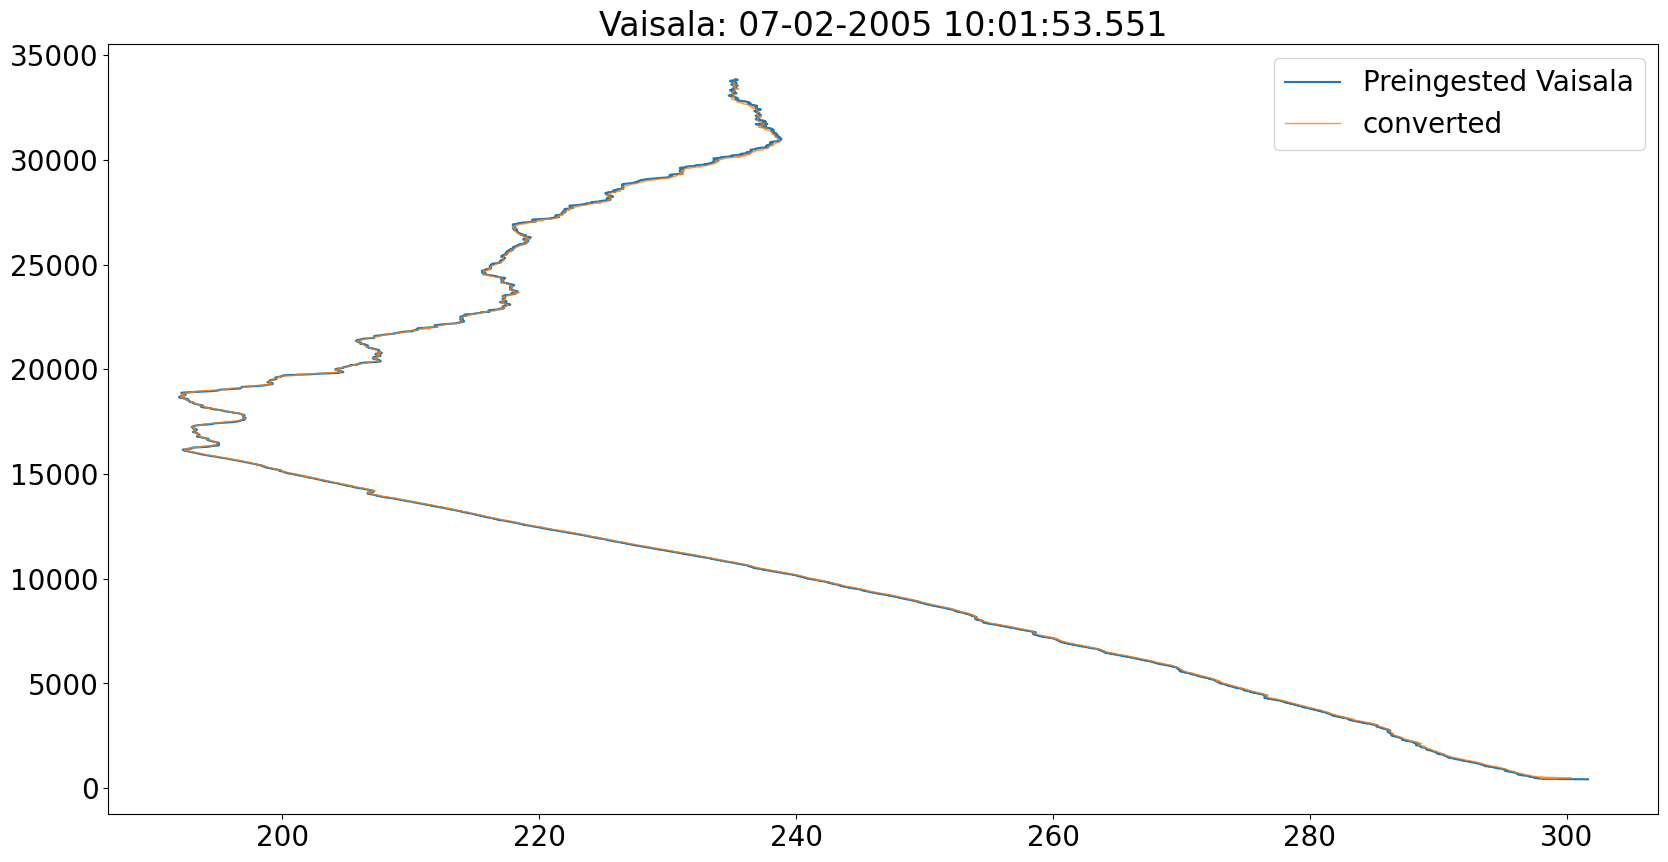

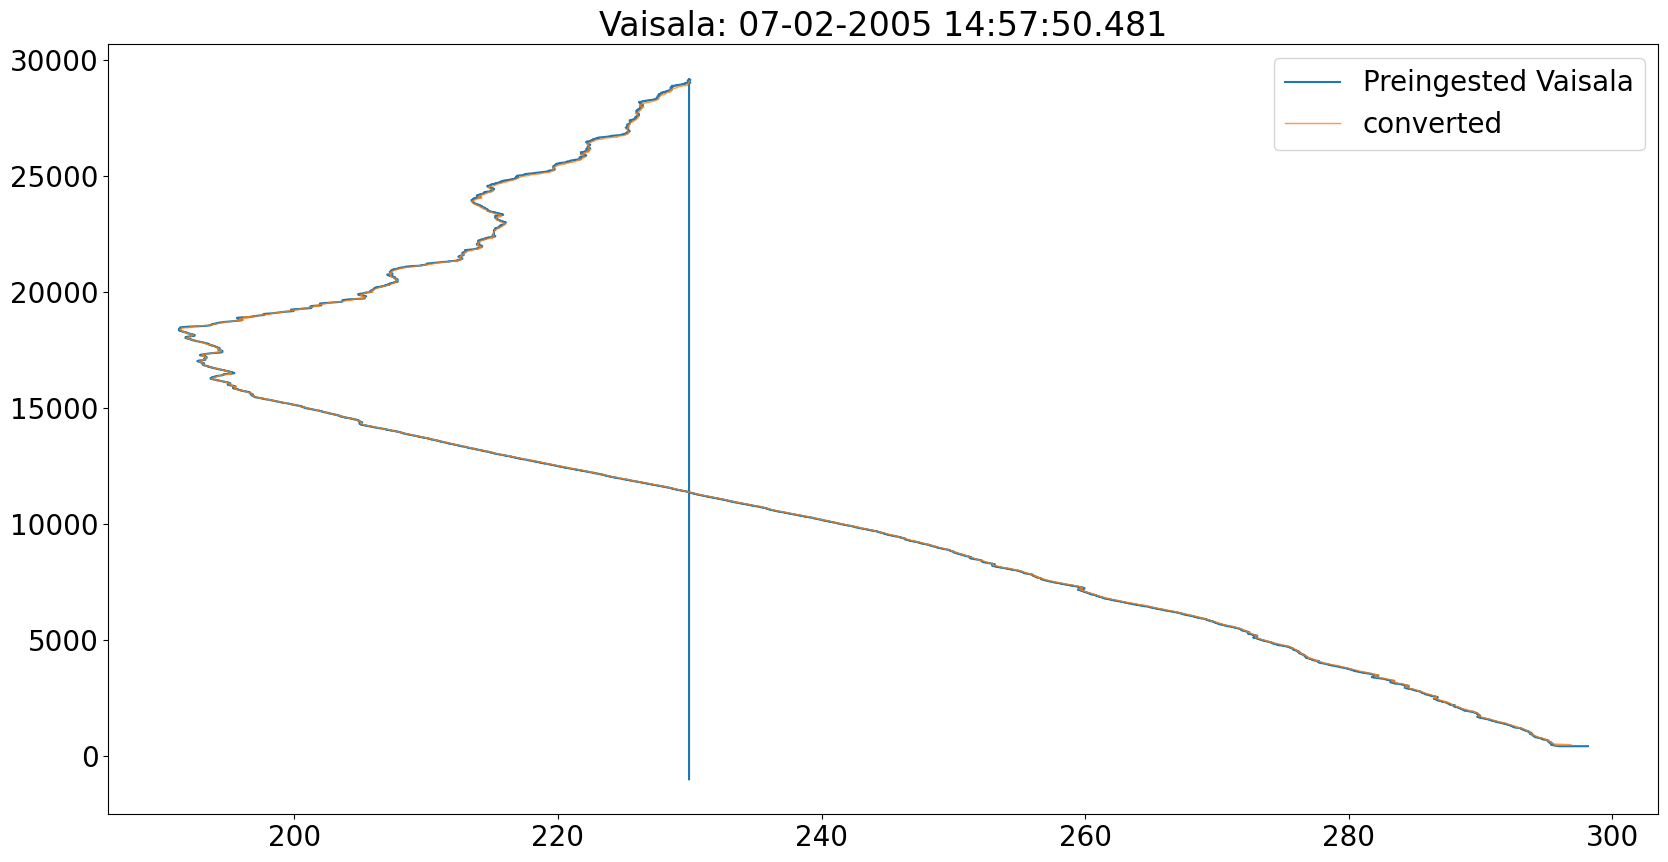

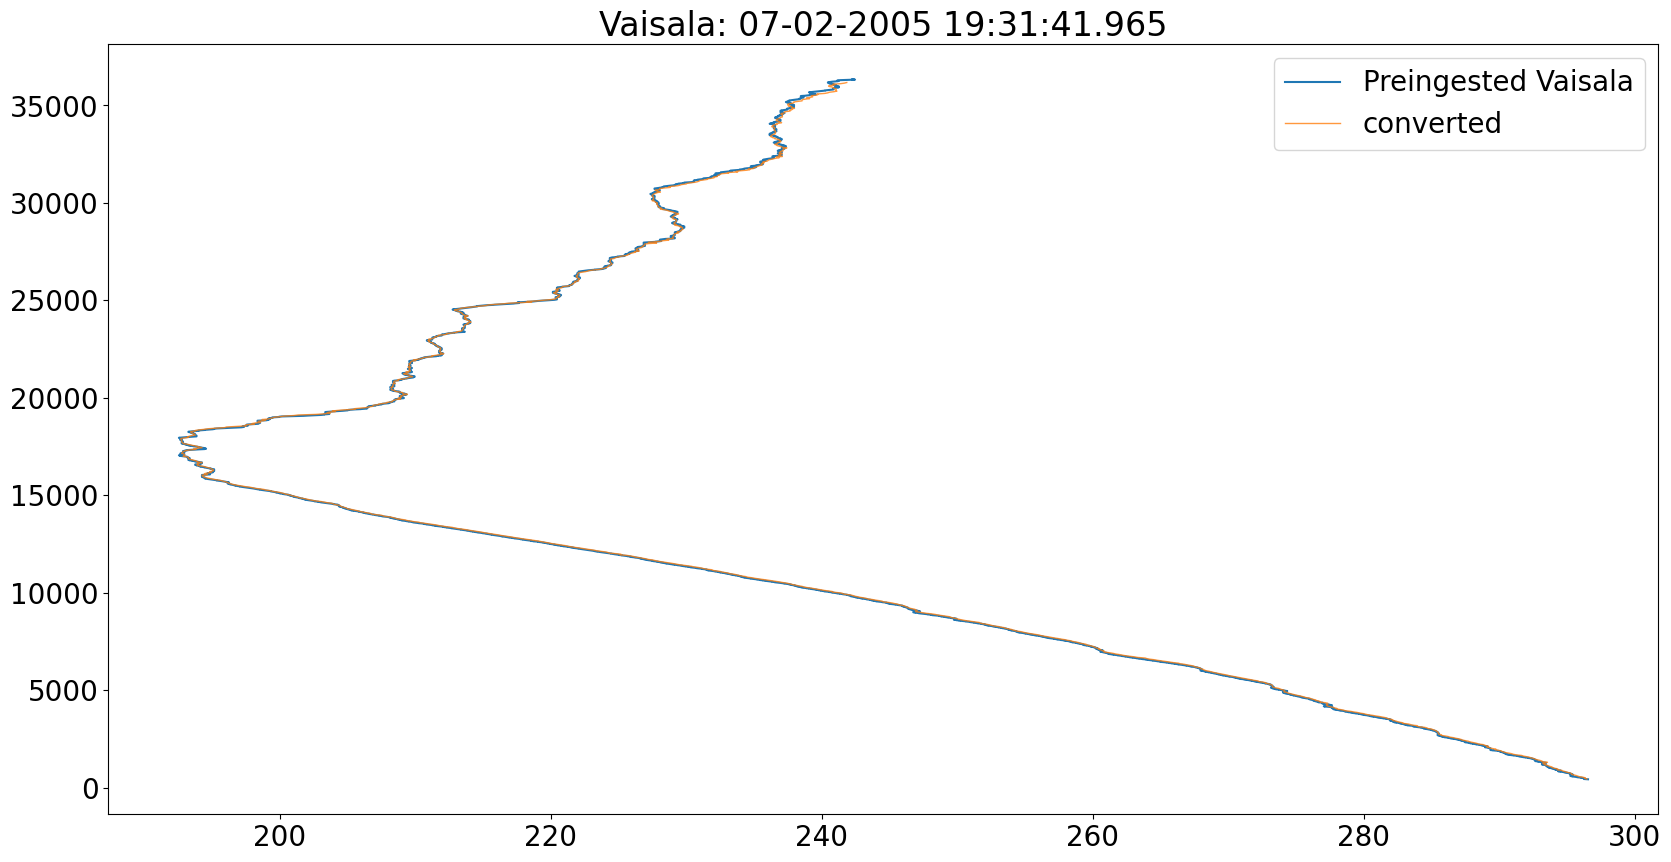

In [74]:
ascs = ['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
for i in range(len(ascs)):
    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs[i]]
    vais_df = vais_df[vais_df.pressure > 0]
    vais_df.temperature = vais_df.temperature + 273.15
    df = pd.read_csv(glob.glob('./out_height/Vaisala_'+str(i+1)+'_.csv')[0])
    plt.plot(vais_df.temperature, vais_df.height, label='Preingested Vaisala')#, alpha = 0.4, linewidth = 6)
    plt.plot(df.temp, df.press*1000., alpha = 0.8, linewidth = 1, label='converted')
    plt.legend()
    plt.title('Vaisala: ' + ascs[i])
    ax = plt.gca()
    # ax.set_yscale('log')
    # ax.set_ylim(ax.get_ylim()[::-1])
    plt.show()
    plt.close()

In [56]:
# vais_df = pd.read_csv('./vaisala_ascents.csv')
# vais_df = vais_df[vais_df.date_time == "07-02-2005 14:57:50.481"]
# vais_df = vais_df[vais_df.pressure > 0]
# vais_df.temperature = vais_df.temperature + 273.15
# df = pd.read_csv(glob.glob('./out_data/Vaisala_2.csv')[0])
# plt.plot(vais_df.temperature, vais_df.pressure, label='Preingested Vaisala')#, alpha = 0.4, linewidth = 6)
# plt.plot(df.temp, df.press, alpha = 0.8, linewidth = 1, label='converted')
# plt.legend()
# ax = plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])

## height converted and xls

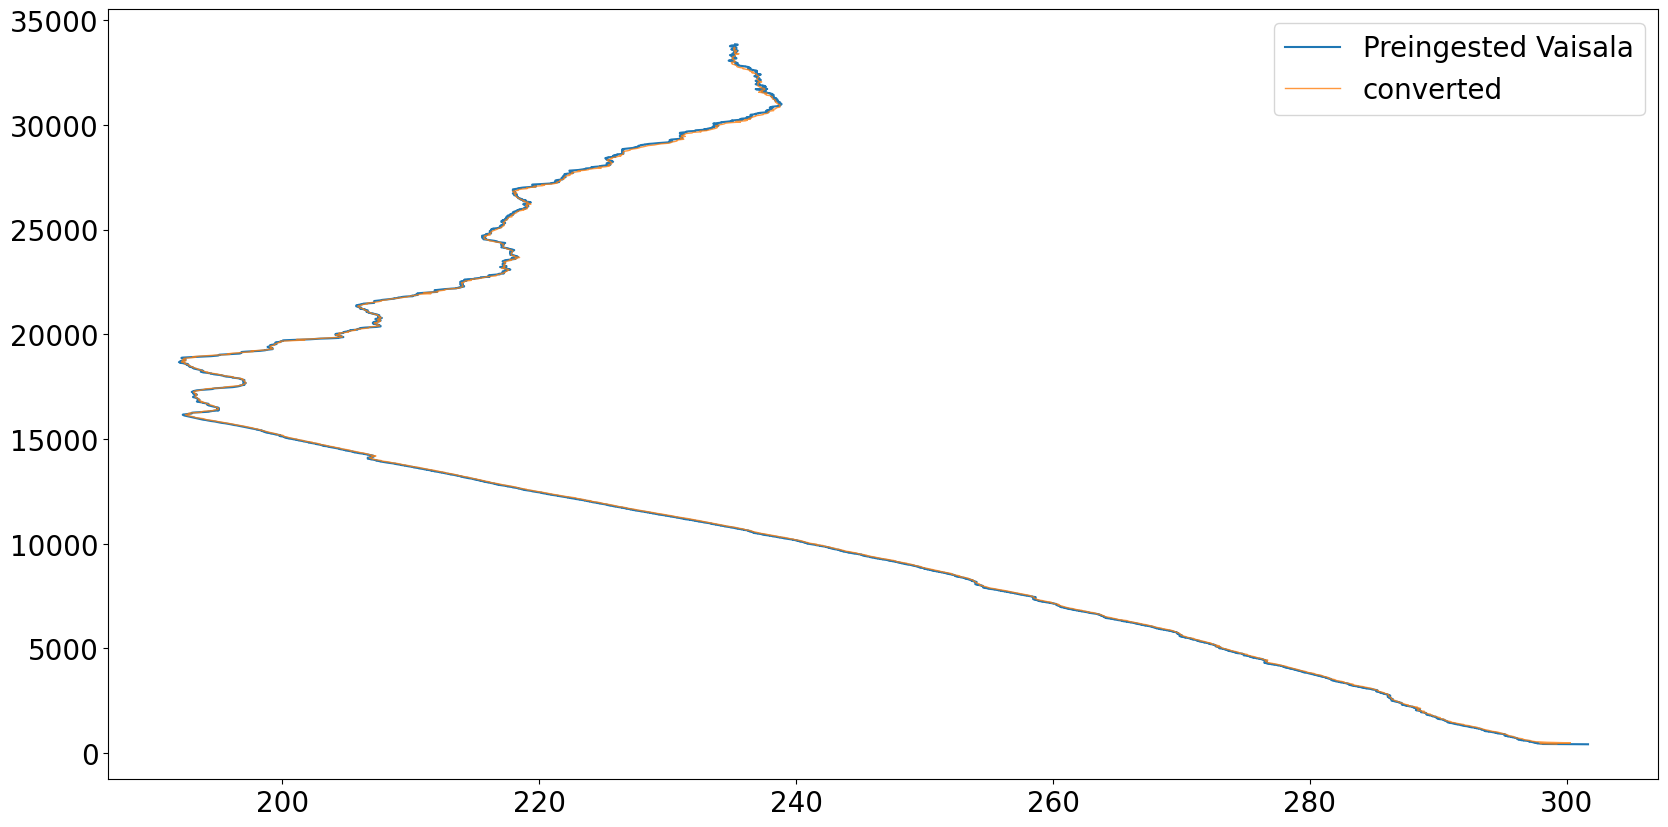

In [57]:
vais_df = pd.read_csv('./vaisala_ascents.csv')
vais_df = vais_df[vais_df.date_time == "07-02-2005 10:01:53.551"]
vais_df = vais_df[vais_df.height > 0]
vais_df.temperature = vais_df.temperature + 273.15
df = pd.read_csv(glob.glob('./out_height/Vaisala_1_.csv')[0])
plt.plot(vais_df.temperature, vais_df.height, label='Preingested Vaisala') #, alpha = 0.4, linewidth = 4)
plt.plot(df.temp, df.press*1000, alpha = 0.8, linewidth = 1, label='converted')
plt.legend()
ax = plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])

In [58]:
# vais_df = pd.read_csv('./vaisala_ascents.csv')
# vais_df = vais_df[vais_df.date_time == "07-02-2005 14:57:50.481"]
# vais_df = vais_df[vais_df.height > 0]
# vais_df.temperature = vais_df.temperature + 273.15
# df = pd.read_csv(glob.glob('./out_height/Vaisala_2_.csv')[0])
# plt.plot(vais_df.temperature, vais_df.height, label='Preingested Vaisala') #, alpha = 0.4, linewidth = 4)
# plt.plot(df.temp, df.press*1000, alpha = 0.8, linewidth = 1, label='converted')
# plt.legend()
# ax = plt.gca()
# # ax.set_yscale('log')
# # ax.set_ylim(ax.get_ylim()[::-1])

## zoomed:

(1232.6518653517428, 5.226715004533365)

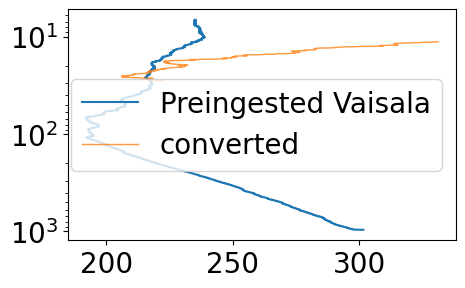

In [110]:
vais_df = pd.read_csv('./vaisala_ascents.csv')
vais_df = vais_df[vais_df.date_time == "07-02-2005 10:01:53.551"]
vais_df = vais_df[vais_df.pressure > 0]
vais_df.temperature = vais_df.temperature + 273.15
df = pd.read_csv(glob.glob('./out_data_zoomed/Vaisala_1_1_.csv')[0])
# df = pd.read_csv(glob.glob('./out_data/Vaisala_1.csv')[0])
plt.plot(vais_df.temperature, vais_df.pressure, label='Preingested Vaisala')#, alpha = 0.4, linewidth = 6)
plt.plot(df.temp, df.press, alpha = 0.8, linewidth = 1, label='converted')
plt.legend()
ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])

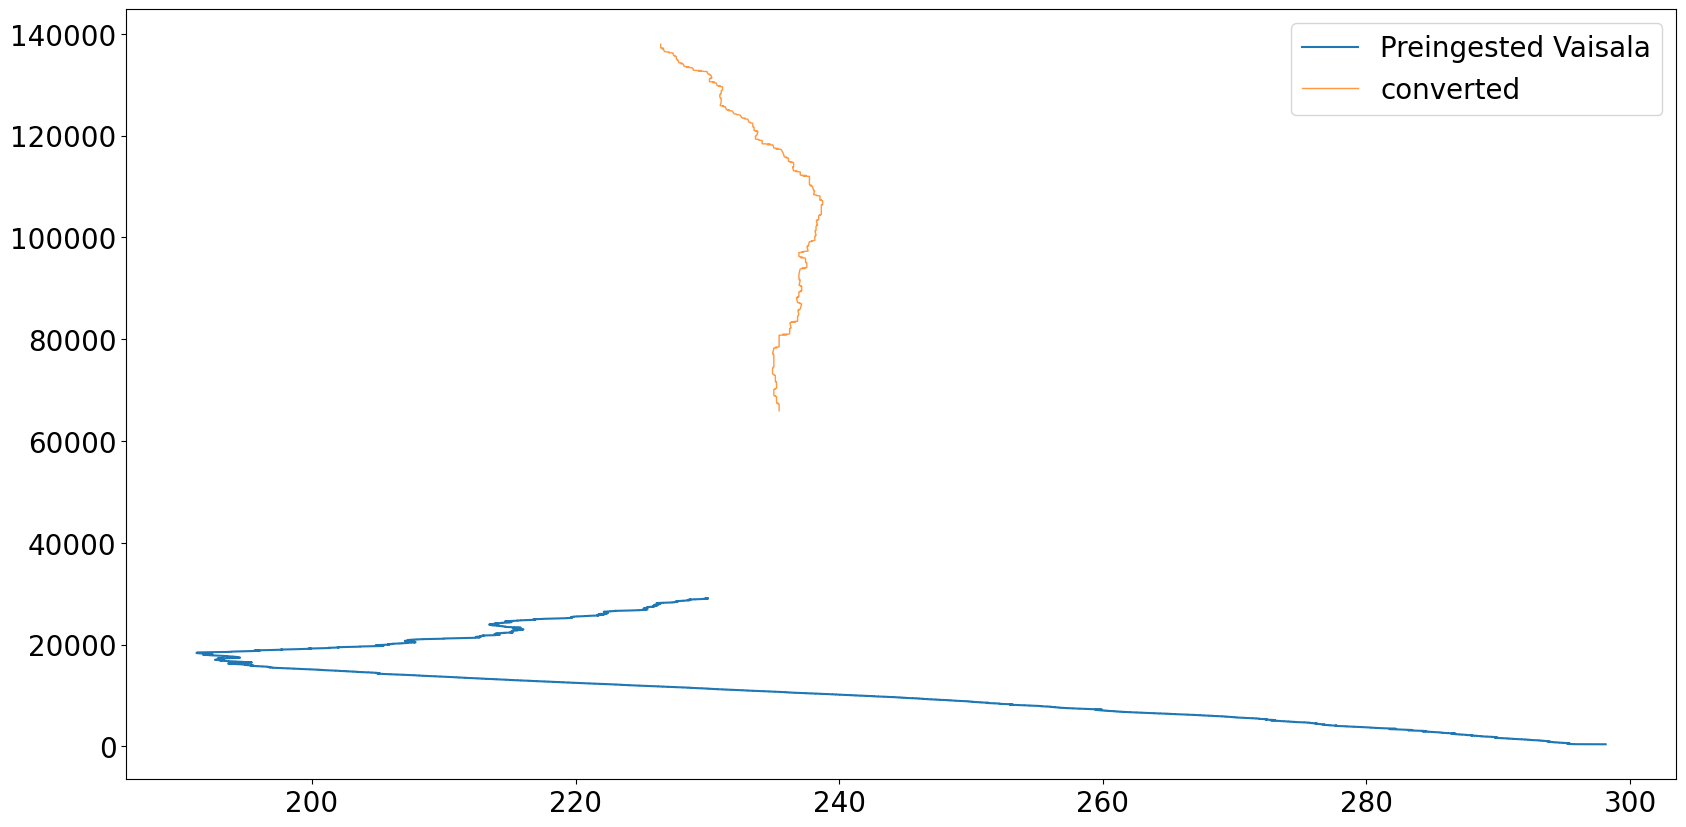

In [64]:
vais_df = pd.read_csv('./vaisala_ascents.csv')
vais_df = vais_df[vais_df.date_time == "07-02-2005 14:57:50.481"]
vais_df = vais_df[vais_df.height > 0]
vais_df.temperature = vais_df.temperature + 273.15
df = pd.read_csv(glob.glob('./out_height/Vaisala_1_0_.csv')[0])
plt.plot(vais_df.temperature, vais_df.height, label='Preingested Vaisala') #, alpha = 0.4, linewidth = 4)
plt.plot(df.temp, df.press*1000, alpha = 0.8, linewidth = 1, label='converted')
plt.legend()
ax = plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])

In [40]:
df

,Unnamed: 0,press,temp
0,1214,0.438356,299.215960
1,1213,0.465753,297.920318
2,1212,0.493151,300.276031
3,1211,0.520548,298.450353
4,1210,0.547945,297.566961
...,...,...,...
1210,4,33.589041,235.140577
1211,3,33.616438,235.140577
1212,2,33.643836,235.258363
1213,1,33.671233,235.140577


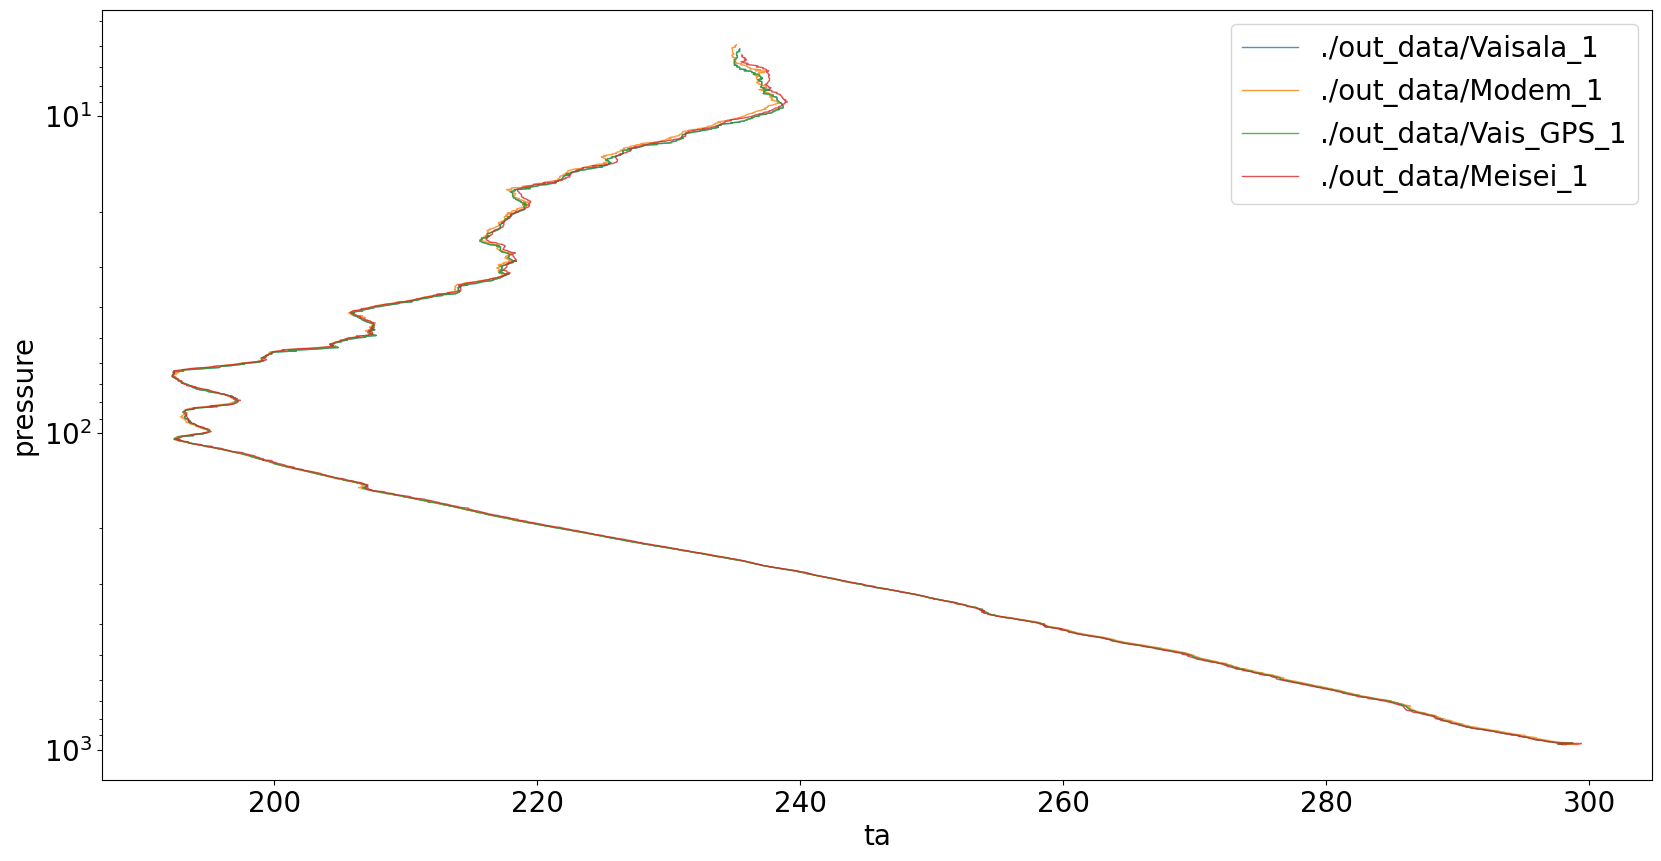

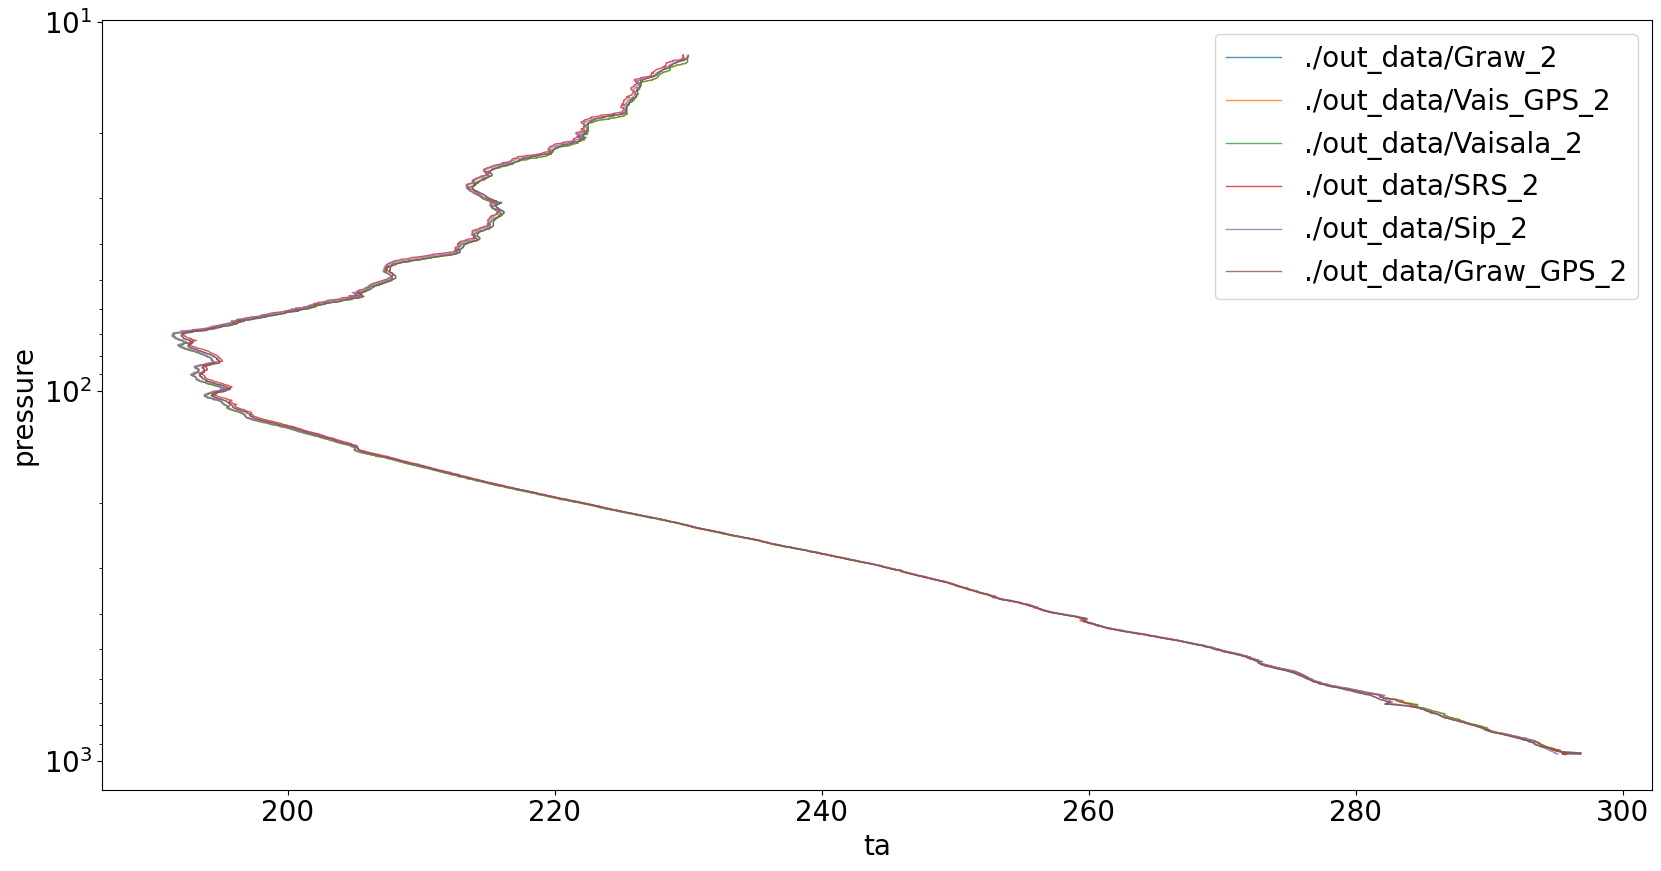

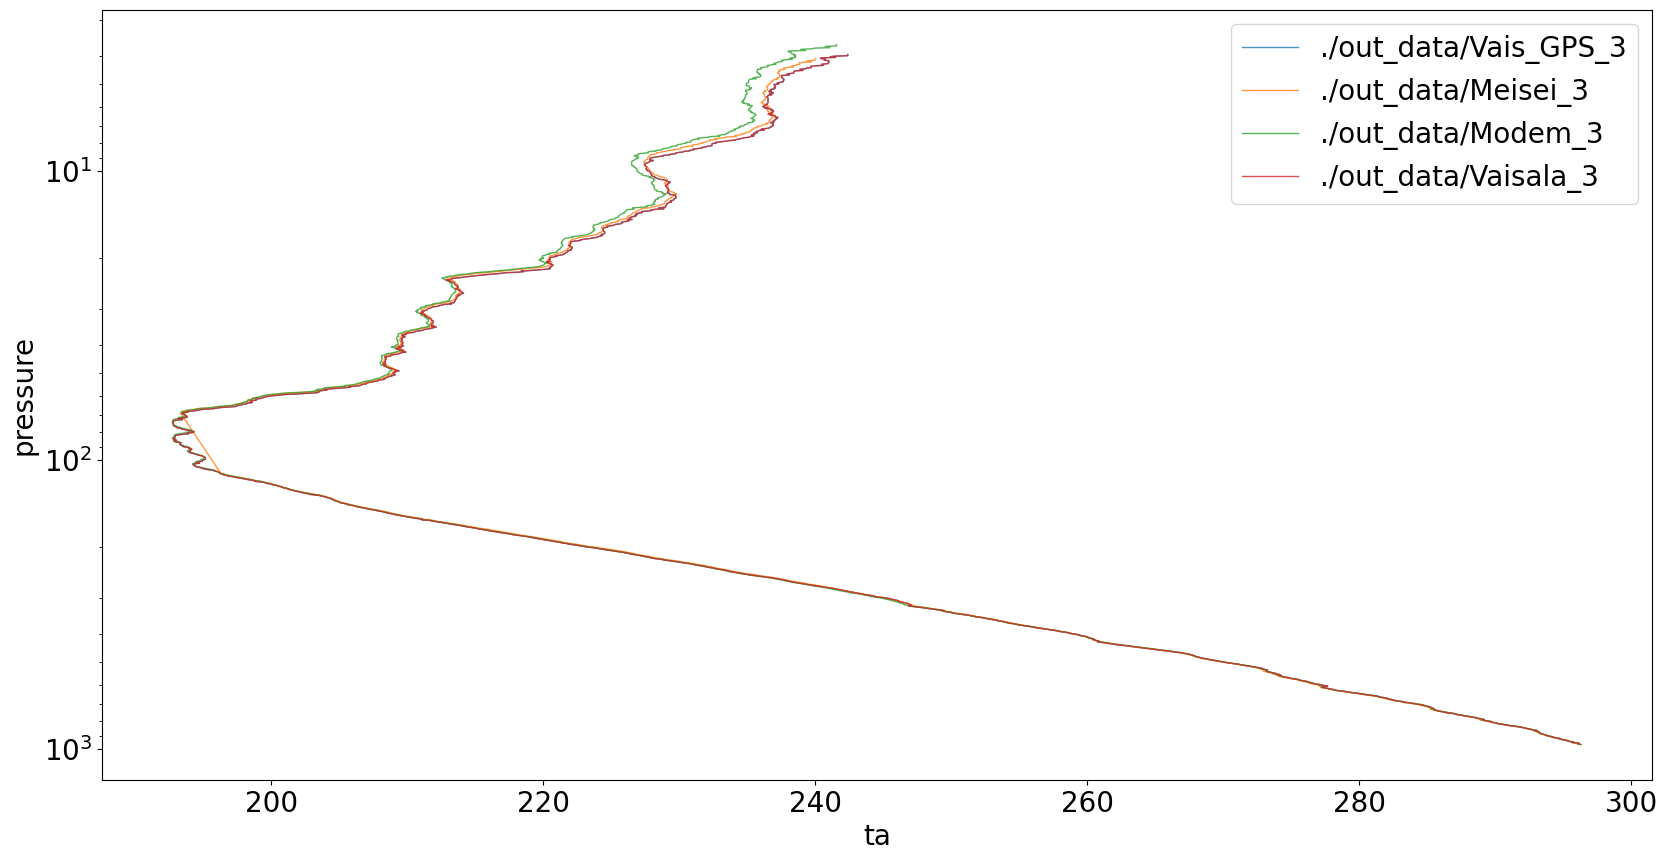

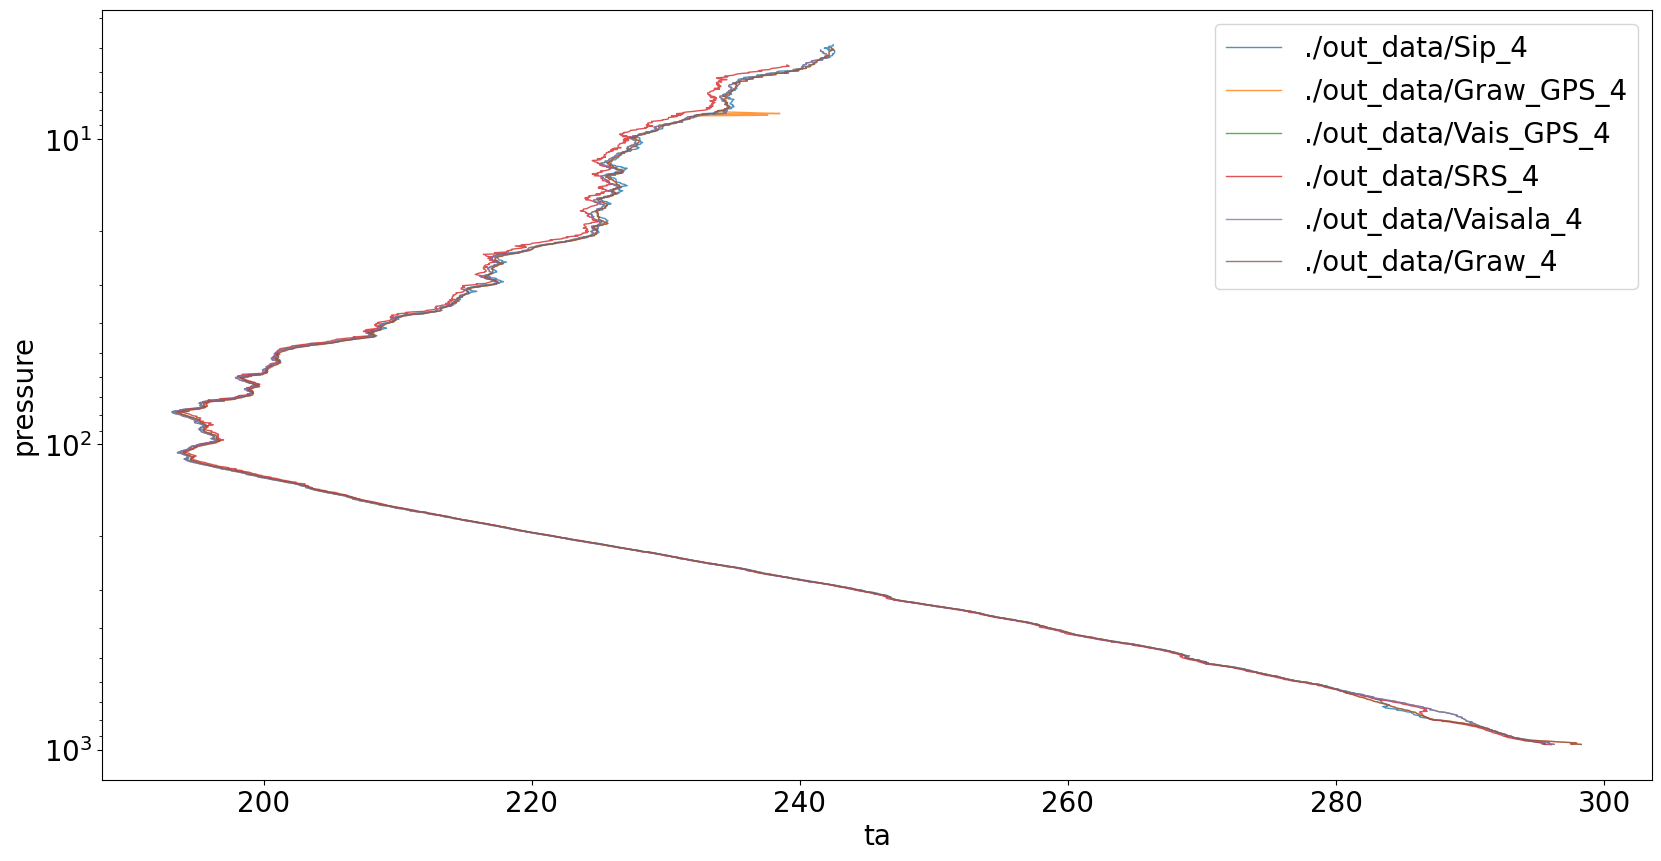

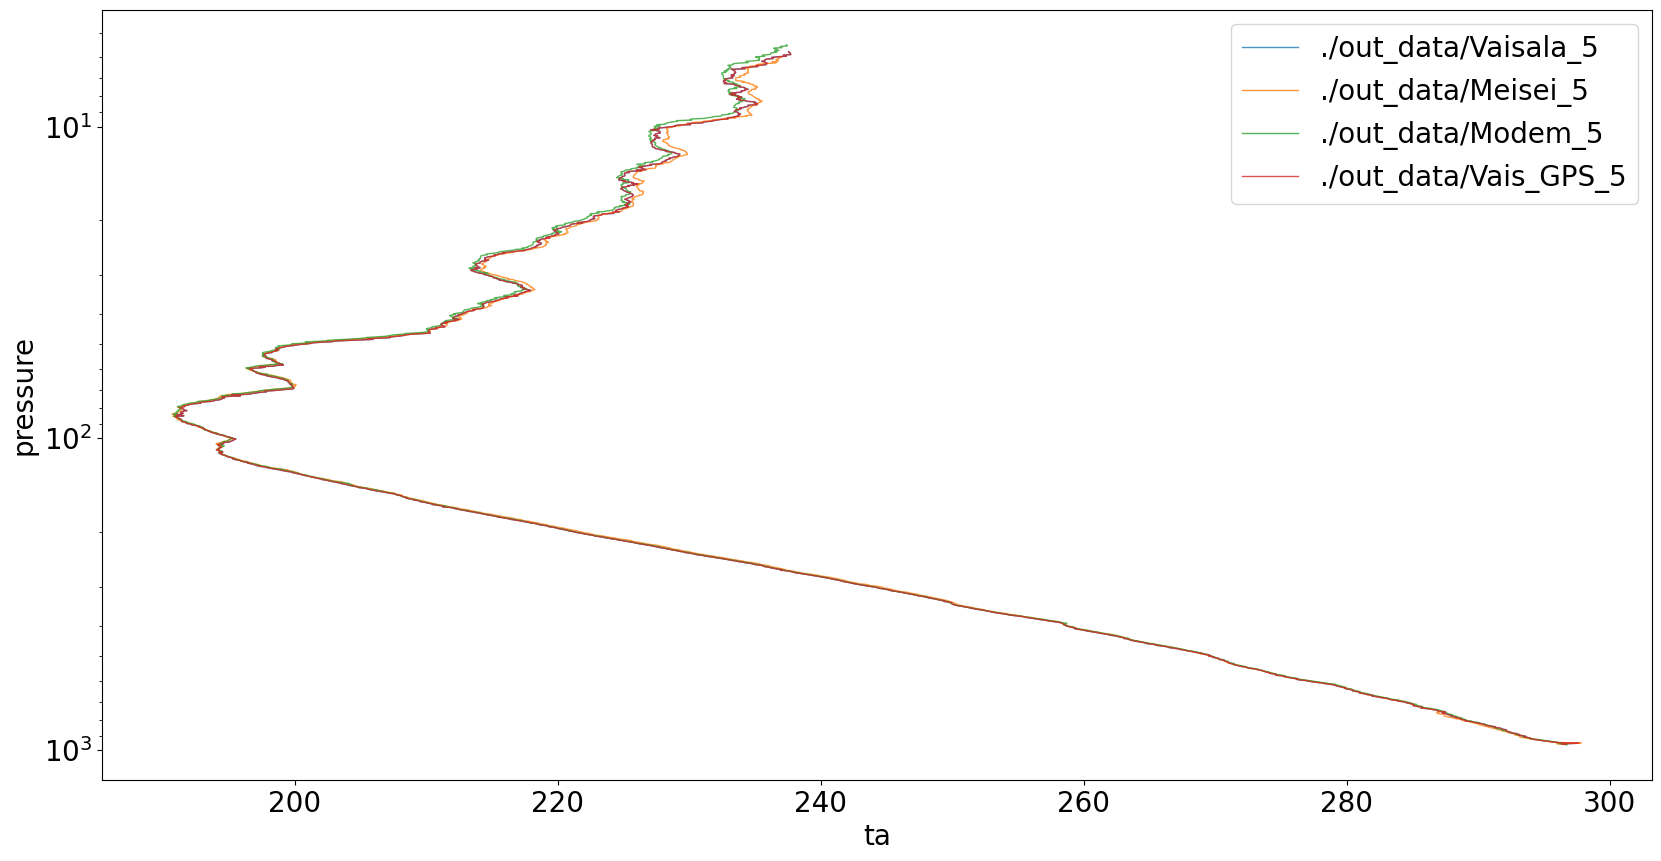

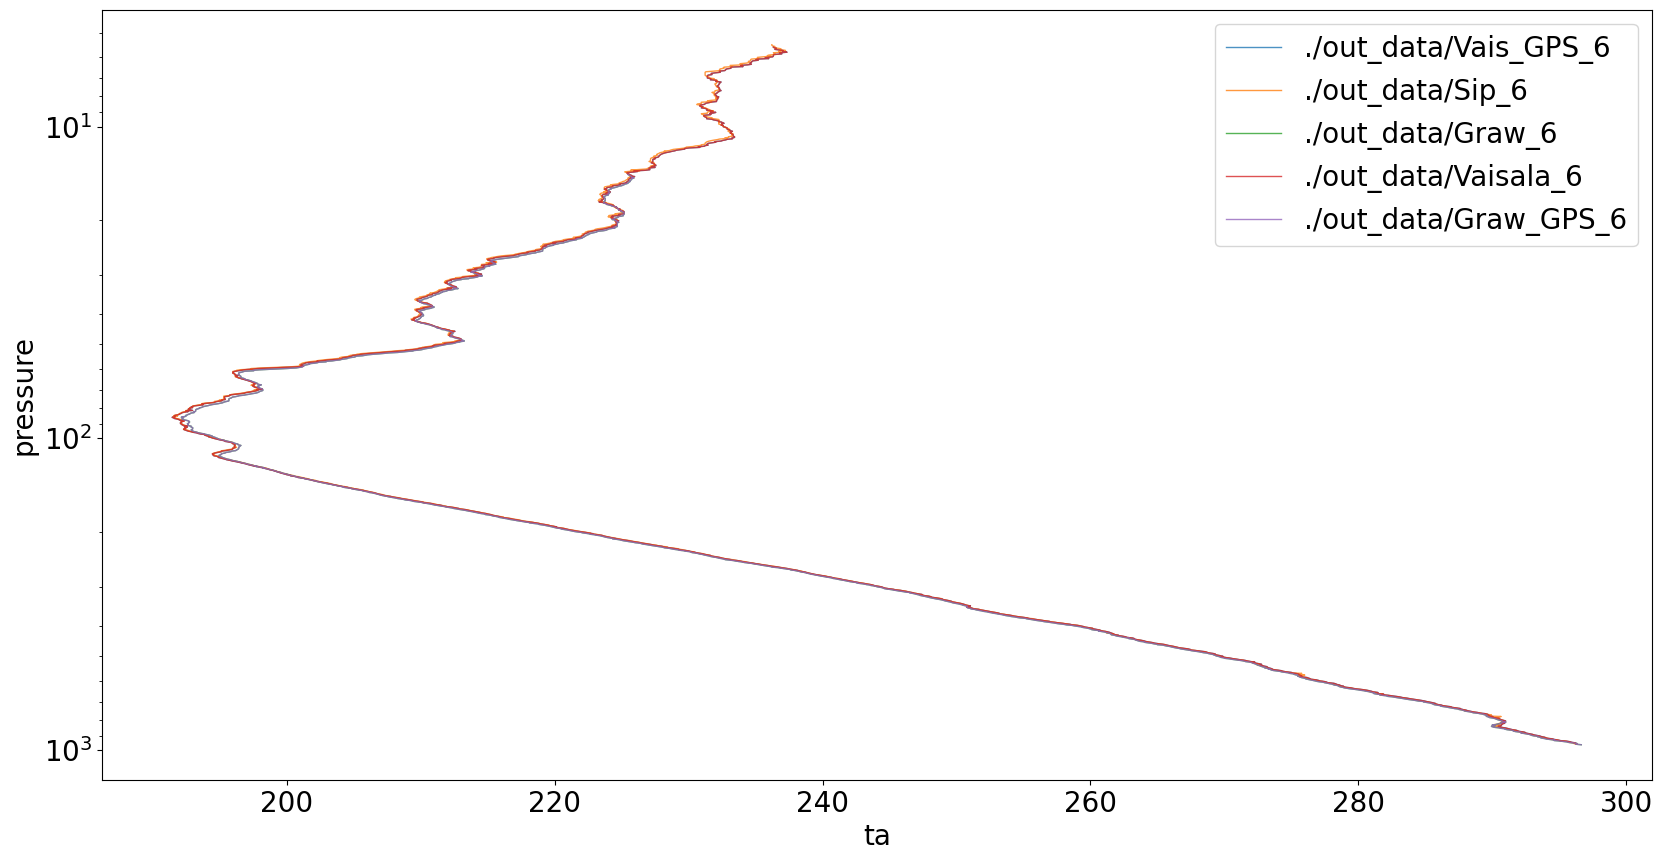

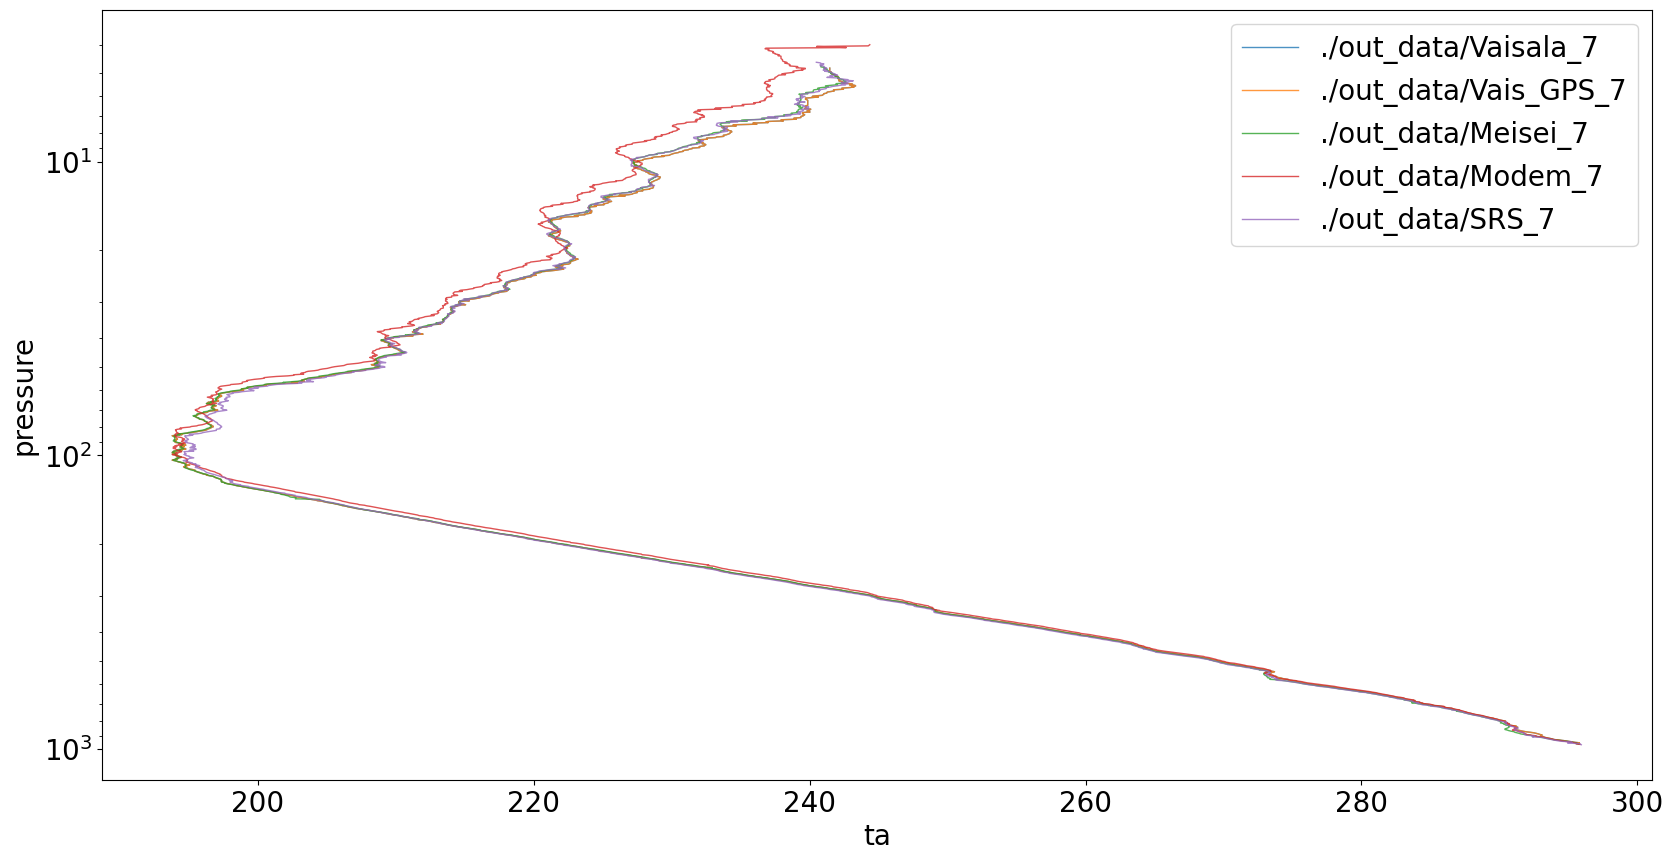

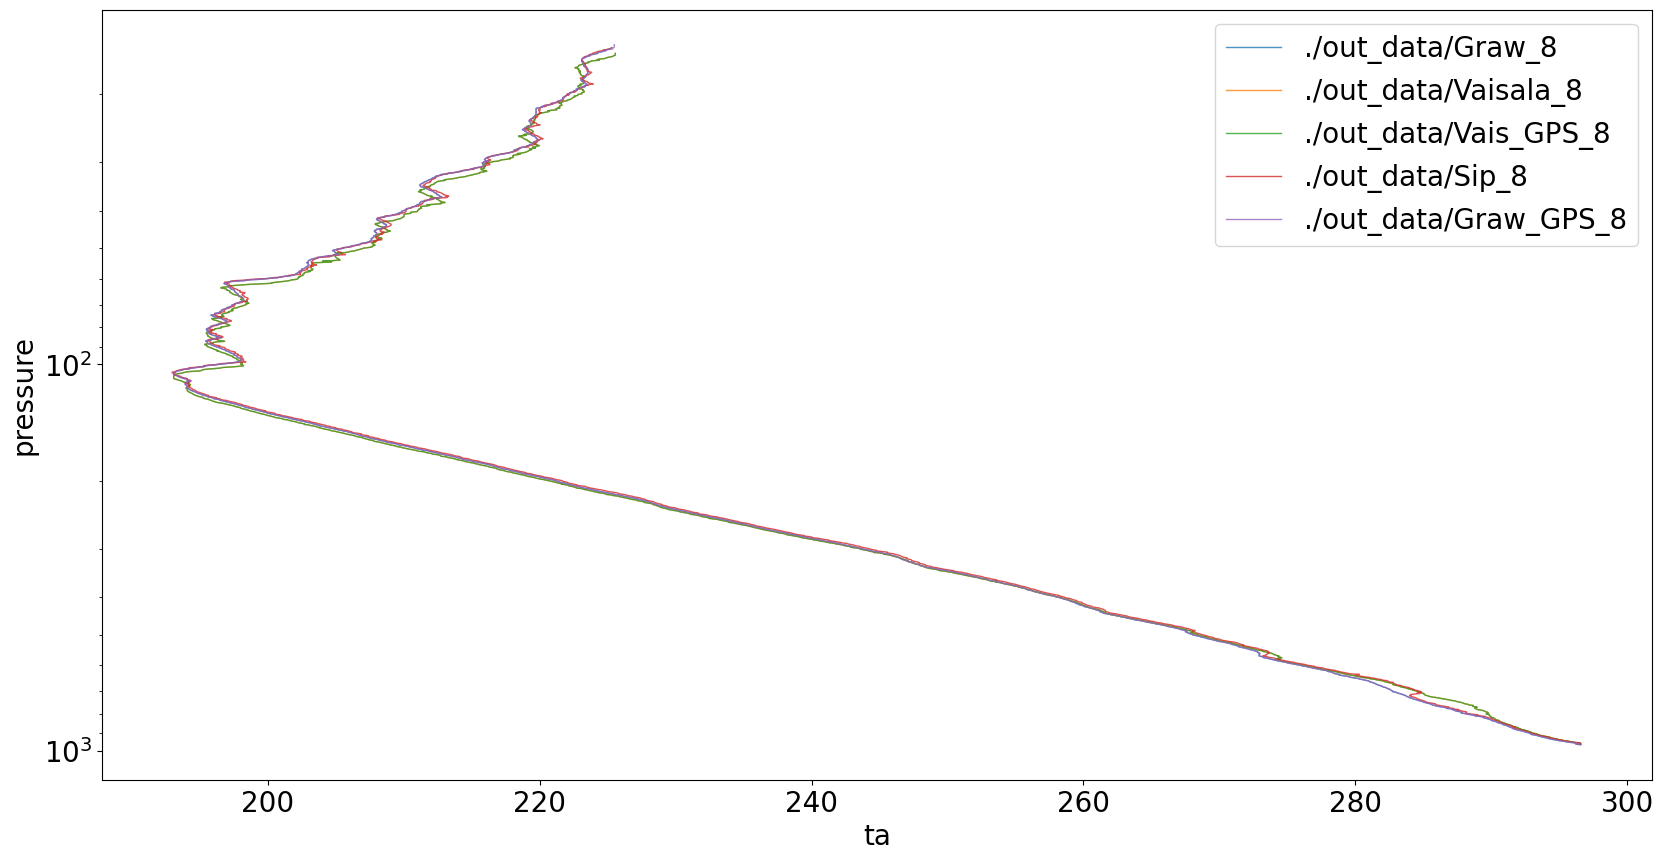

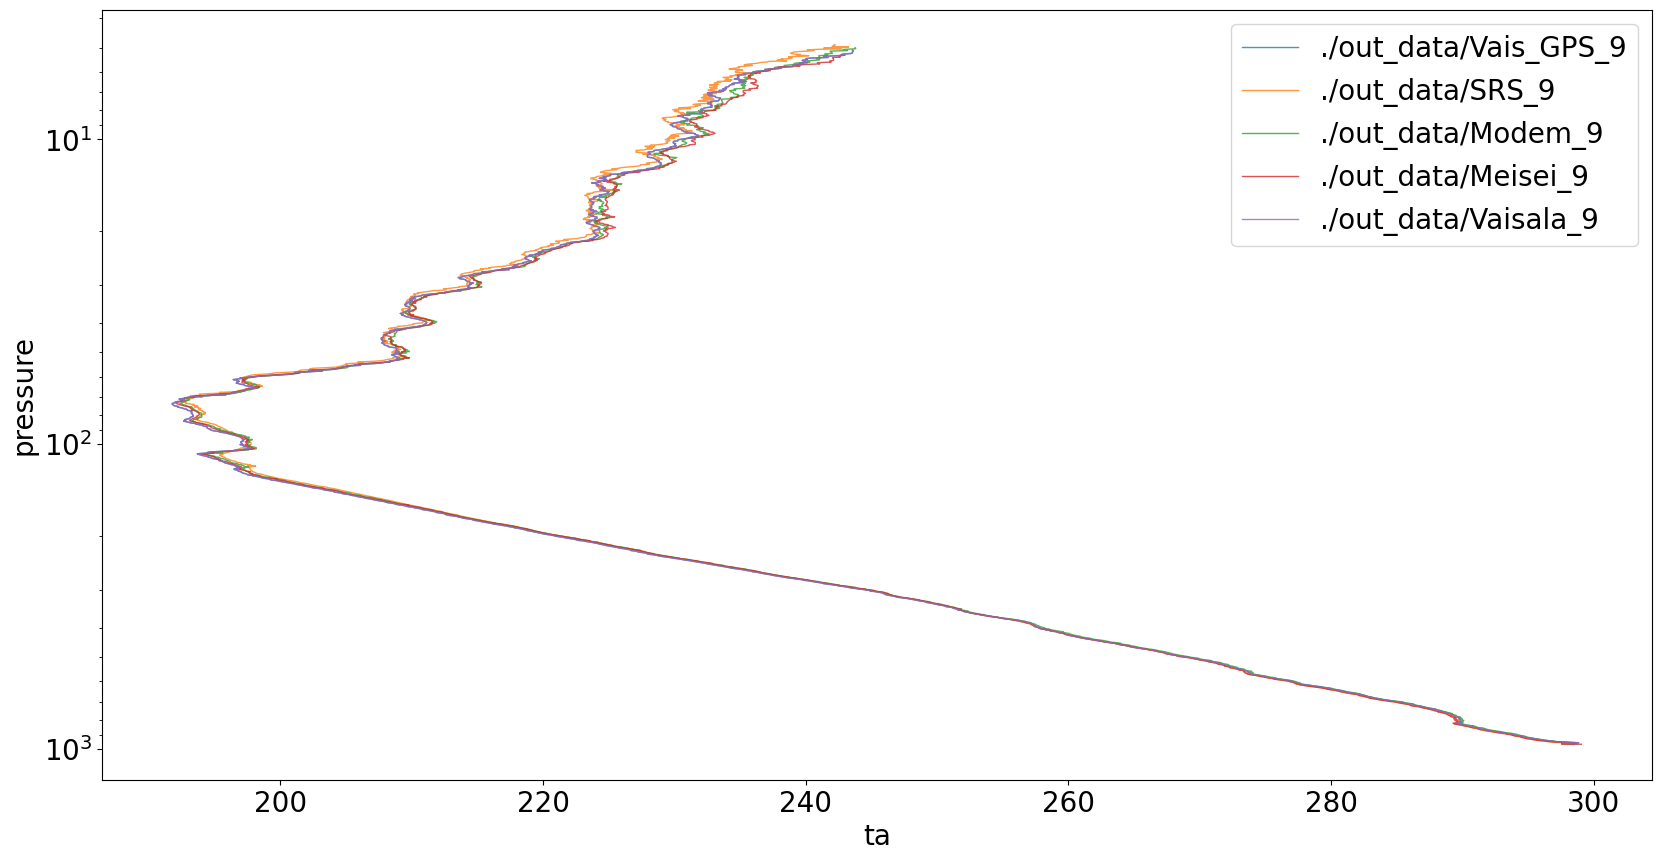

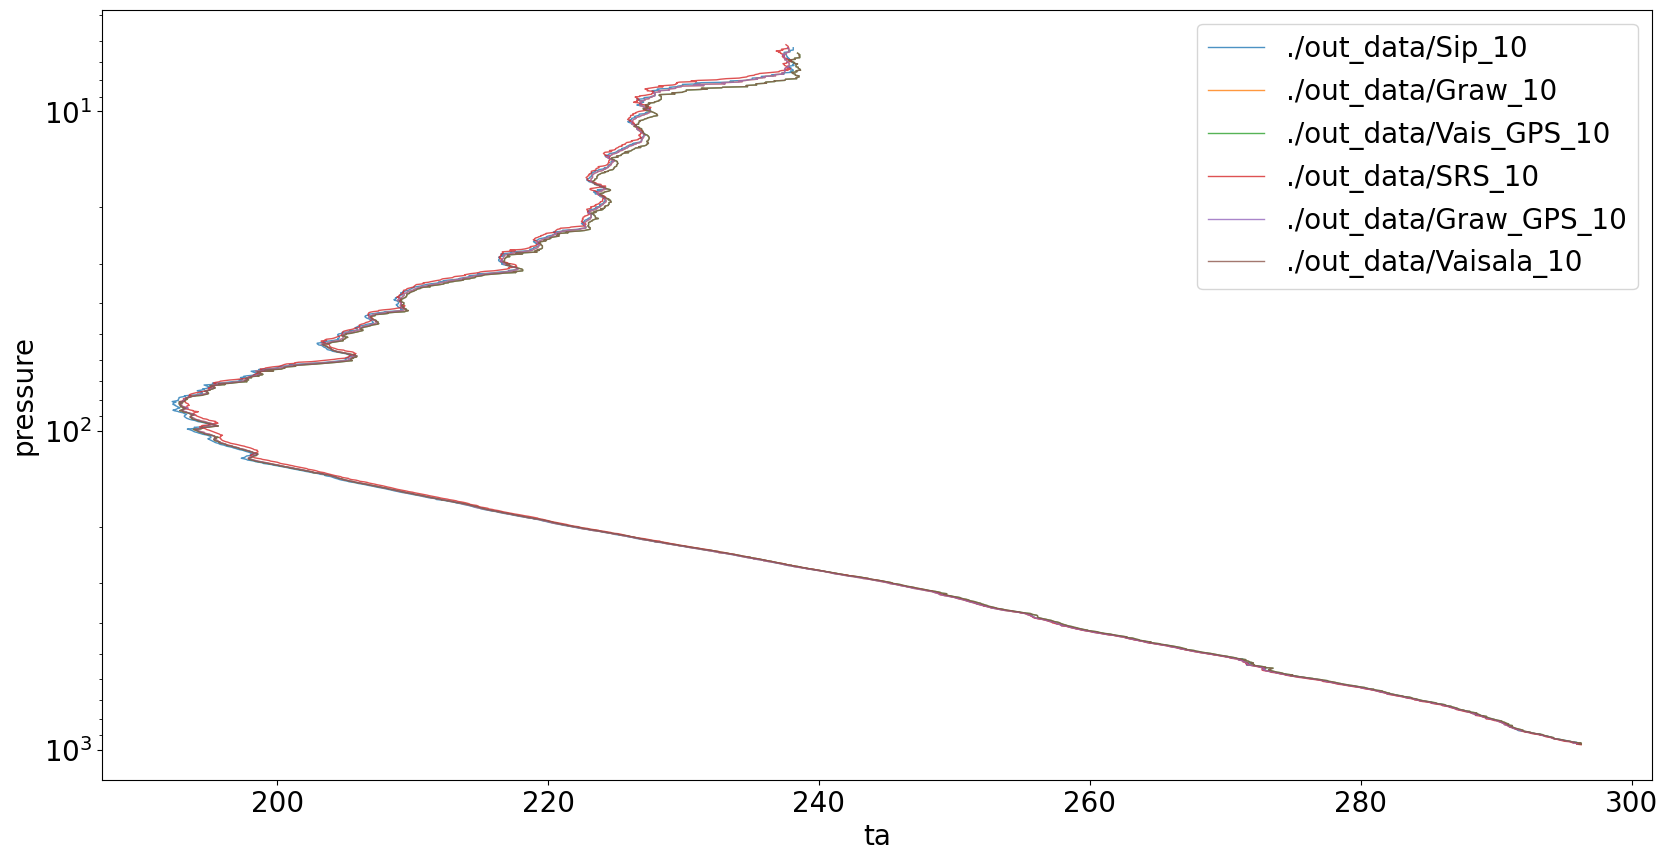

In [160]:
for j in range(1,11):
    for i in glob.glob('./out_data/*_'+str(j)+'.csv'):
        df = pd.read_csv(i)
        plt.plot(df.temp, df.press, label=i.split('.csv')[0], alpha = 0.8, linewidth = 1)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.xlabel("ta")
    plt.ylabel("pressure")
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
# def digitize(file):    
#     %matplotlib inline
#     # Load the image
#     img = cv2.imread(file)
#     plt.imshow(img)
#     plt.show()
#     plt.close()

#     # Convert the image to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Apply a threshold to create a binary image
#     thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Find the contours in the binary image
#     contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#     # Find the contour with the largest area (i.e., the plot data)
#     largest_contour = max(contours, key=cv2.contourArea)

#     # Get the bounding box of the contour
#     x, y, w, h = cv2.boundingRect(largest_contour)

#     # Crop the image to the bounding box
#     plot_only = img[y+10:y+h-1, x+1:x+w-1]
#     relative_y = y+10
#     relative_x = x+1
#     relative_y_xaxis =  y+h-1

#     # Save the cropped image
#     cv2.imwrite('test_plot_only.png', plot_only)

#     # Show the cropped image
#     plt.imshow(plot_only)
#     plt.show()

#     # Convert the contour to a numpy array and transpose it
#     plot_data = largest_contour.squeeze().T

#     # Print the plot data
#     print(plot_data)

    
    
    
#     image = img[ 1272:1285, 20:500]
#     plt.imshow(image)
#     plt.show()
#     plt.close()
#     if np.mean(image) == 255:
#         print('All white')
#         return 0
#     else:
#         print('Not all white')
        
#     image_l = image_resize(image, height = 50)
#     gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Morph open to remove noise and invert image
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#     inverted = 255 - opening

#     data = pytesseract.image_to_string(inverted, lang='eng', config= '--psm 7')
#     print(data)
        
        
        
#     print('start splitting image')

#     im = cv2.imread("test_plot_only.png")

#     # Define lower and upper limits of our blue
#     BlueMax = np.array([128, 255, 255], np.uint8)
#     BlueMin = np.array([90, 50, 70], np.uint8)

#     # Go to HSV colourspace and get mask of blue pixels
#     HSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
#     plt.imshow(HSV)
#     plt.show()
#     plt.close()
#     mask = cv2.inRange(HSV, BlueMin, BlueMax)

#     # Make all pixels in mask white
#     grid = copy.copy(im)
#     grid[mask == 0] = [255, 255, 255]
#     grid[0:, 0:15] = [255, 255, 255]


#     im[mask > 0] = [255, 255, 255]
#     im[0:100, 0:15] = [255, 255, 255]
#     im[-2:, :] = [255, 255, 255]
    
#     plt.imshow(im)
#     plt.show()
#     plt.close()
#     plt.imshow(grid)
#     plt.show()
#     plt.close()
#     cv2.imwrite("test_grid_only.png", grid)
#     cv2.imwrite("test_data_only.png", im)
    
    
    
#     print("Analyzig grid:")

#     grid = cv2.imread('test_grid_only.png')
#     gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

#     gray = np.float32(gray)

#     dst = cv2.cornerHarris(gray, 5,19,0.07)
#     dst = cv2.dilate(dst, None)

#     # Get coordinates
#     ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
#     dst = np.uint8(dst)

#     # find centroids
#     ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
#     # define the criteria to stop and refine the corners
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 
#                 0.001)
#     corners = cv2.cornerSubPix(gray,np.float32(centroids[1:]),(5,5), 
#           (-1,-1),criteria)
#     # To draw the corners
#     for corner in corners:
#         grid[int(corner[1]), int(corner[0])] = [0, 0, 255]
#     corner_coords = np.asarray(corners, dtype = int)
#     for co in corner_coords:
#         grid = cv2.circle(grid, co, radius=4, color=(255, 0, 0), thickness=-1)
#     plt.imshow(grid)
#     plt.show()
#     plt.close()
    
    
    
#     # choosing 2 points
#     grid = cv2.imread('test_grid_only.png')
#     maxcoord = np.argmax(np.sum(corner_coords, axis = 1))
#     mincoord = np.argmin(np.sum(corner_coords, axis = 1))

#     # coords_mean = meancoord
#     coords_low = corner_coords[mincoord]
#     coords_high = corner_coords[maxcoord]
#     grid = cv2.circle(grid, coords_low, radius=4, color=(0, 0, 255), thickness=-1)
#     grid = cv2.circle(grid, coords_high, radius=4, color=(0, 0, 255), thickness=-1)
#     print('min: ', coords_low)
#     print('max: ', coords_high)
#     # print('mean: ', coords_mean)

#     plt.imshow(grid)
#     plt.show()
#     plt.close()
    
    
    
#     rs_h = 50 # resize height
#     set_psm = '--psm 7'
#     matplotlib.rcParams["figure.figsize"] = (5, 3)
#     whole_image = cv2.imread(file)

#     low_y_label = whole_image[relative_y + coords_low[1]-10: relative_y + coords_low[1]+10, relative_x-37:relative_x-1]
#     low_y_label = image_resize(low_y_label, height = rs_h)

#     gray = cv2.cvtColor(low_y_label, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Morph open to remove noise and invert image
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#     inverted = 255 - opening

#     low_y_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
#     print("low_y: ", low_y_val)

#     plt.imshow(low_y_label)
#     plt.show()
#     plt.close()

#     high_y_label = whole_image[relative_y + coords_high[1]-10: relative_y + coords_high[1]+10, relative_x-37:relative_x-1]
#     high_y_label = image_resize(high_y_label, height = rs_h)

#     gray = cv2.cvtColor(high_y_label, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Morph open to remove noise and invert image
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#     inverted = 255 - opening

#     high_y_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
#     print("high_y: ", high_y_val)

#     plt.imshow(high_y_label)
#     plt.show()
#     plt.close()

#     low_x_label = whole_image[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_low[0]-20:relative_x+coords_low[0]+30]
#     low_x_label = image_resize(low_x_label, height = rs_h)

#     gray = cv2.cvtColor(low_x_label, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Morph open to remove noise and invert image
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#     inverted = 255 - opening

#     low_x_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
#     print("low_x: ", low_x_val)

#     plt.imshow(low_x_label)
#     plt.show()
#     plt.close()

#     high_x_label = whole_image[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_high[0]-30:relative_x+coords_high[0]+30]
#     high_x_label = image_resize(high_x_label, height = rs_h)

#     gray = cv2.cvtColor(high_x_label, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Morph open to remove noise and invert image
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#     inverted = 255 - opening

#     high_x_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
#     print("high_x: ", high_x_val)

#     plt.imshow(high_x_label)
#     plt.show()
#     plt.close()
    
#     matplotlib.rcParams["figure.figsize"] = (20, 10)
    
    
    
#     # converting axis texts to data:
#     print('low: ',coords_low, low_x_val, low_y_val)
#     print('high: ',coords_high, high_x_val, high_y_val)
#     xa_p = [coords_low[0], coords_high[0]]
#     xa_v = [273.15+int("".join([x for x in low_x_val.split('\n\x0c')[0]  if x.isdigit() or x=='-'])), 273.15+int("".join([x for x in high_x_val.split('\n\x0c')[0]  if x.isdigit() or x=='-']))]
#     ya_p = [coords_low[1], coords_high[1]]
#     ya_v = [int("".join([x for x in low_y_val.split('\n\x0c')[0]  if x.isdigit() or x=='-'])), int("".join([x for x in high_y_val.split('\n\x0c')[0]  if x.isdigit() or x=='-']))]
#     display(xa_p)
#     display(xa_v)
#     display(ya_p)
#     display(ya_v)
    
    
    
#     # calculation of axis functions
#     # x-axis
#     x1 = xa_p[0]
#     a = xa_v[0]
#     x2 = xa_p[1]
#     b = xa_v[1]

#     m_T = (b - a) / (x2 - x1)
#     c_T = a - m_T * x1
#     def T(x):
#         return m_T * x + c_T

#     # y-axis
#     y1 = ya_p[0]
#     ap = np.log(ya_v[0])
#     y2 = ya_p[1]
#     bp = np.log(ya_v[1])

#     m = (bp - ap) / (y2 - y1)
#     c = ap - m * y1
#     def P(x):
#         return m * x + c
    
    
    
#     # selection of data points via contour of graph:
#     graph = cv2.imread('test_data_only.png')
#     edge = cv2.Canny(graph, 30, 200) 
#     ans = []
#     for y in range(0, edge.shape[0]):
#         for x in range(0, edge.shape[1]):
#             if edge[y, x] != 0:
#                 ans = ans + [[x, y]]
#     ans = np.array(ans)

#     print(ans.shape)
#     print(ans[0:10, :])

#     for co in ans[0::20]:
#         image = cv2.circle(graph, co, radius=4, color=(255, 0, 0), thickness=-1)
#     plt.imshow(image)
#     plt.show()
#     plt.close()
    
    
    
#     # points to data with functions:
#     out = {}
#     out['press'] = np.exp(P(ans[0::20][:,1]))
#     out['temp'] = (T(ans[0::20][:,0]))
#     df = pd.DataFrame.from_dict(out)
#     df = df.sort_values('press')
#     return df